<h1>SELF DRIVING CAR</h1>

__LOADING AND SPLITTING THE DATASET (70:30)__

In [0]:
import cv2

In [0]:
import scipy.misc
import random

xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

In [0]:
from PIL import Image
import numpy as np

In [0]:
print(num_train_images)
print(num_val_images)

31784
13621


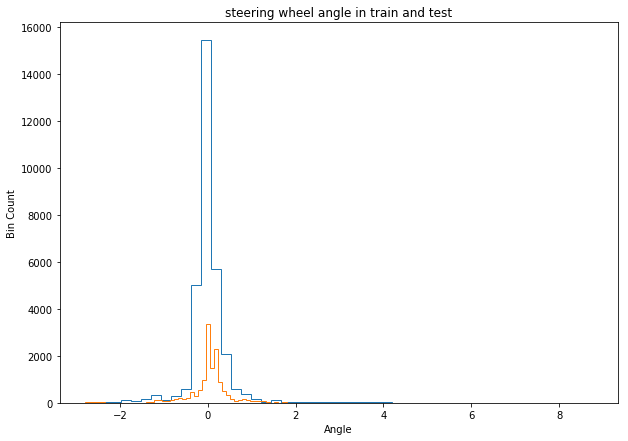

In [0]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,7))
plt.hist(train_ys,bins=50 , histtype="step")
plt.hist(val_ys,bins=50 , histtype="step")
plt.title("steering wheel angle in train and test")
plt.xlabel('Angle')
plt.ylabel('Bin Count')
plt.show()


__AS YOU CAN see most of the TIME IS ANGLE 0 because the car is moving straight most of the time__

In [0]:
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(train_x[(train_batch_pointer + i) % len(train_x)]) #here % len(train_x) is used to make sure that
        #"train_batch_pointer + i" should not cross the number of train images. As soon as the value of "train_batch_pointer" is
        #equal to number of train images then it will again start reading the train images from the beginning means from 0th
        #index onwards.
        read_image_road = read_image[-150:] #here, we are taking only the lower part of the images where there is a road in the
        #image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper
        #part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.
        read_image_resize = cv2.resize(read_image_road, (200, 66)) #After, resizing, each image will be of size (66, 200, 3). 
        #now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 
        #Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(train_y[(train_batch_pointer + i) % len(train_y)]) #appending corresponding labels
        
    train_batch_pointer += batch_size
        
    return x_result, y_result

def LoadTestBatch(batch_size):
    global test_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(test_x[(test_batch_pointer + i) % len(test_x)]) #here % len(test_x) is used to make sure that
        #"test_batch_pointer + i" should not cross the number of test images. As soon as the value of "test_batch_pointer" is
        #equal to number of test images then it will again start reading the test images from the beginning means from 0th
        #index onwards.
        read_image_road = read_image[-150:] #here, we are taking only the lower part of the images where there is a road in the
        #image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper
        #part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.
        read_image_resize = cv2.resize(read_image_road, (200, 66)) #After, resizing, each image will be of size (66, 200, 3). 
        #now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 
        #Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(test_y[(test_batch_pointer + i) % len(test_y)]) #appending corresponding labels
        
    test_batch_pointer += batch_size
        
    return x_result, y_result


__INITIALIZING THE MODEL__

In [0]:
import tensorflow as tf
import scipy

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.identity(tf.matmul(h_fc4_drop, W_fc5) + b_fc5) #simple linear layer


C:\Users\aman\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__TRAINING THE MODEL( ADAM OPTIMIZER 1e-3 , dropout 0.5 , linear layer)__

In [0]:
import os
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import driving_data
import model

LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(driving_data.num_images/batch_size)):
    xs, ys = driving_data.LoadTrainBatch(batch_size)
    train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5})
    if i % 10 == 0:
      xs, ys = driving_data.LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 0.5})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 0.5})
    summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0, Step: 0, Loss: 12.7254
Epoch: 0, Step: 10, Loss: 11.0953
Epoch: 0, Step: 20, Loss: 9.55691
Epoch: 0, Step: 30, Loss: 8.39027
Epoch: 0, Step: 40, Loss: 7.42946
Epoch: 0, Step: 50, Loss: 6.70423
Epoch: 0, Step: 60, Loss: 6.16853
Epoch: 0, Step: 70, Loss: 6.48138
Epoch: 0, Step: 80, Loss: 6.66791
Epoch: 0, Step: 90, Loss: 4.70758
Epoch: 0, Step: 100, Loss: 4.10917
Epoch: 0, Step: 110, Loss: 3.74061
Epoch: 0, Step: 120, Loss: 3.48099
Epoch: 0, Step: 130, Loss: 3.20233
Epoch: 0, Step: 140, Loss: 2.99656
Epoch: 0, Step: 150, Loss: 2.83198
Epoch: 0, Step: 160, Loss: 2.64417
Epoch: 0, Step: 170, Loss: 2.44355
Epoch: 0, Step: 180, Loss: 2.37703
Epoch: 0, Step: 190, Loss: 2.5288
Epoch: 0, Step: 200, Loss: 2.1059
Epoch: 0, Step: 210, Loss: 2.09369
Epoch: 0, Step: 220, Loss: 1.8435
Epoch: 0, Step: 230, Loss: 1.75452
Epoch: 0, Step: 240, Loss: 1.67338
Epoch: 0, Step: 250, Loss: 1.59728
Epoch: 0, Step: 260, Loss: 1.5

Epoch: 2, Step: 230, Loss: 0.23619
Epoch: 2, Step: 240, Loss: 0.20612
Epoch: 2, Step: 250, Loss: 0.31036
Epoch: 2, Step: 260, Loss: 1.22178
Epoch: 2, Step: 270, Loss: 1.48503
Epoch: 2, Step: 280, Loss: 0.244075
Epoch: 2, Step: 290, Loss: 0.305232
Epoch: 2, Step: 300, Loss: 0.172576
Epoch: 2, Step: 310, Loss: 0.169779
Epoch: 2, Step: 320, Loss: 0.17282
Epoch: 2, Step: 330, Loss: 0.172782
Epoch: 2, Step: 340, Loss: 0.195633
Epoch: 2, Step: 350, Loss: 0.178105
Epoch: 2, Step: 360, Loss: 0.155775
Epoch: 2, Step: 370, Loss: 0.279598
Epoch: 2, Step: 380, Loss: 0.575407
Epoch: 2, Step: 390, Loss: 0.293925
Epoch: 2, Step: 400, Loss: 0.235011
Epoch: 2, Step: 410, Loss: 0.144074
Epoch: 2, Step: 420, Loss: 0.141874
Epoch: 2, Step: 430, Loss: 0.137823
Epoch: 2, Step: 440, Loss: 0.133989
Epoch: 2, Step: 450, Loss: 0.194252
Epoch: 2, Step: 460, Loss: 5.53536
Epoch: 2, Step: 470, Loss: 0.321155
Epoch: 2, Step: 480, Loss: 0.128555
Epoch: 2, Step: 490, Loss: 0.120728
Epoch: 2, Step: 500, Loss: 0.122863

Epoch: 4, Step: 520, Loss: 0.0723463
Epoch: 4, Step: 530, Loss: 0.112003
Epoch: 4, Step: 540, Loss: 0.050272
Epoch: 4, Step: 550, Loss: 0.0608426
Epoch: 4, Step: 560, Loss: 0.165254
Epoch: 4, Step: 570, Loss: 0.44314
Epoch: 4, Step: 580, Loss: 0.270553
Epoch: 4, Step: 590, Loss: 0.0554702
Epoch: 4, Step: 600, Loss: 0.0501419
Epoch: 4, Step: 610, Loss: 0.0505556
Epoch: 4, Step: 620, Loss: 0.0500503
Epoch: 4, Step: 630, Loss: 0.049417
Epoch: 4, Step: 640, Loss: 0.517731
Epoch: 4, Step: 650, Loss: 4.94275
Epoch: 4, Step: 660, Loss: 0.0788622
Epoch: 4, Step: 670, Loss: 0.0480271
Epoch: 4, Step: 680, Loss: 0.0441904
Epoch: 4, Step: 690, Loss: 0.050626
Epoch: 4, Step: 700, Loss: 0.0443759
Epoch: 4, Step: 710, Loss: 0.0420995
Epoch: 4, Step: 720, Loss: 0.0343647
Epoch: 4, Step: 730, Loss: 0.0346728
Epoch: 4, Step: 740, Loss: 0.0339743
Epoch: 4, Step: 750, Loss: 0.0331451
Epoch: 4, Step: 760, Loss: 0.0352148
Epoch: 4, Step: 770, Loss: 0.0694554
Epoch: 4, Step: 780, Loss: 0.069211
Epoch: 4, Ste

Epoch: 6, Step: 810, Loss: 0.0230651
Epoch: 6, Step: 820, Loss: 0.025884
Epoch: 6, Step: 830, Loss: 1.55599
Epoch: 6, Step: 840, Loss: 4.04121
Epoch: 6, Step: 850, Loss: 0.0268948
Epoch: 6, Step: 860, Loss: 0.0163662
Epoch: 6, Step: 870, Loss: 0.0157052
Epoch: 6, Step: 880, Loss: 0.0192112
Epoch: 6, Step: 890, Loss: 0.0166847
Epoch: 6, Step: 900, Loss: 0.0174159
Epoch: 6, Step: 910, Loss: 0.0160158
Epoch: 6, Step: 920, Loss: 0.0159379
Epoch: 6, Step: 930, Loss: 0.0162895
Epoch: 6, Step: 940, Loss: 0.0127837
Epoch: 6, Step: 950, Loss: 0.017719
Epoch: 6, Step: 960, Loss: 0.0521968
Epoch: 6, Step: 970, Loss: 0.0511297
Epoch: 6, Step: 980, Loss: 0.0200114
Epoch: 6, Step: 990, Loss: 0.0116096
Epoch: 6, Step: 1000, Loss: 0.012041
Epoch: 6, Step: 1010, Loss: 0.0121754
Epoch: 6, Step: 1020, Loss: 0.0112301
Epoch: 6, Step: 1030, Loss: 0.0118721
Epoch: 6, Step: 1040, Loss: 0.0113854
Epoch: 6, Step: 1050, Loss: 0.0104673
Model saved in file: ./save\model.ckpt
Epoch: 7, Step: 700, Loss: 0.0113899


Epoch: 8, Step: 1110, Loss: 0.00572445
Epoch: 8, Step: 1120, Loss: 0.00646949
Epoch: 8, Step: 1130, Loss: 0.00462296
Epoch: 8, Step: 1140, Loss: 0.0158223
Epoch: 8, Step: 1150, Loss: 0.0552101
Epoch: 8, Step: 1160, Loss: 0.0475243
Epoch: 8, Step: 1170, Loss: 0.00489425
Epoch: 8, Step: 1180, Loss: 0.00475777
Epoch: 8, Step: 1190, Loss: 0.00551878
Epoch: 8, Step: 1200, Loss: 0.00548217
Epoch: 8, Step: 1210, Loss: 0.0051689
Epoch: 8, Step: 1220, Loss: 0.0081478
Epoch: 8, Step: 1230, Loss: 0.00417061
Epoch: 8, Step: 1240, Loss: 0.00541132
Epoch: 8, Step: 1250, Loss: 0.00875202
Model saved in file: ./save\model.ckpt
Epoch: 9, Step: 900, Loss: 0.0061328
Epoch: 9, Step: 910, Loss: 0.00762575
Epoch: 9, Step: 920, Loss: 0.0056117
Epoch: 9, Step: 930, Loss: 0.00526566
Epoch: 9, Step: 940, Loss: 0.00555416
Epoch: 9, Step: 950, Loss: 0.0063732
Epoch: 9, Step: 960, Loss: 0.0408121
Epoch: 9, Step: 970, Loss: 0.0362323
Epoch: 9, Step: 980, Loss: 5.00289
Epoch: 9, Step: 990, Loss: 0.46019
Epoch: 9, St

Epoch: 10, Step: 1410, Loss: 0.00320833
Epoch: 10, Step: 1420, Loss: 0.00158287
Epoch: 10, Step: 1430, Loss: 0.00176932
Epoch: 10, Step: 1440, Loss: 0.00245561
Epoch: 10, Step: 1450, Loss: 0.00229418
Model saved in file: ./save\model.ckpt
Epoch: 11, Step: 1100, Loss: 0.00189361
Epoch: 11, Step: 1110, Loss: 0.00160503
Epoch: 11, Step: 1120, Loss: 0.00159291
Epoch: 11, Step: 1130, Loss: 0.00161725
Epoch: 11, Step: 1140, Loss: 0.0028914
Epoch: 11, Step: 1150, Loss: 0.0527437
Epoch: 11, Step: 1160, Loss: 0.133857
Epoch: 11, Step: 1170, Loss: 5.23718
Epoch: 11, Step: 1180, Loss: 0.0200835
Epoch: 11, Step: 1190, Loss: 0.00231478
Epoch: 11, Step: 1200, Loss: 0.0374878
Epoch: 11, Step: 1210, Loss: 0.0723384
Epoch: 11, Step: 1220, Loss: 0.069844
Epoch: 11, Step: 1230, Loss: 0.0060468
Epoch: 11, Step: 1240, Loss: 0.128659
Epoch: 11, Step: 1250, Loss: 0.0546261
Epoch: 11, Step: 1260, Loss: 0.00228167
Epoch: 11, Step: 1270, Loss: 0.0590393
Epoch: 11, Step: 1280, Loss: 0.0103223
Epoch: 11, Step: 12

Epoch: 12, Step: 1640, Loss: 0.00316793
Epoch: 12, Step: 1650, Loss: 0.00265617
Model saved in file: ./save\model.ckpt
Epoch: 13, Step: 1300, Loss: 0.00318286
Epoch: 13, Step: 1310, Loss: 0.00246496
Epoch: 13, Step: 1320, Loss: 0.00286114
Epoch: 13, Step: 1330, Loss: 0.00640165
Epoch: 13, Step: 1340, Loss: 0.0617363
Epoch: 13, Step: 1350, Loss: 1.15811
Epoch: 13, Step: 1360, Loss: 4.35186
Epoch: 13, Step: 1370, Loss: 0.00834084
Epoch: 13, Step: 1380, Loss: 0.00145378
Epoch: 13, Step: 1390, Loss: 0.0485258
Epoch: 13, Step: 1400, Loss: 0.0670282
Epoch: 13, Step: 1410, Loss: 0.068728
Epoch: 13, Step: 1420, Loss: 0.0174557
Epoch: 13, Step: 1430, Loss: 0.126501
Epoch: 13, Step: 1440, Loss: 0.0205012
Epoch: 13, Step: 1450, Loss: 0.00849652
Epoch: 13, Step: 1460, Loss: 0.0415995
Epoch: 13, Step: 1470, Loss: 0.0156403
Epoch: 13, Step: 1480, Loss: 0.0109334
Epoch: 13, Step: 1490, Loss: 0.0717269
Epoch: 13, Step: 1500, Loss: 0.13248
Epoch: 13, Step: 1510, Loss: 0.0616815
Epoch: 13, Step: 1520, L

Epoch: 15, Step: 1510, Loss: 0.000548095
Epoch: 15, Step: 1520, Loss: 0.00473506
Epoch: 15, Step: 1530, Loss: 0.0614076
Epoch: 15, Step: 1540, Loss: 2.35145
Epoch: 15, Step: 1550, Loss: 3.03074
Epoch: 15, Step: 1560, Loss: 0.00319268
Epoch: 15, Step: 1570, Loss: 0.000742033
Epoch: 15, Step: 1580, Loss: 0.0652403
Epoch: 15, Step: 1590, Loss: 0.0732302
Epoch: 15, Step: 1600, Loss: 0.0623893
Epoch: 15, Step: 1610, Loss: 0.0444386
Epoch: 15, Step: 1620, Loss: 0.12259
Epoch: 15, Step: 1630, Loss: 0.00483294
Epoch: 15, Step: 1640, Loss: 0.0277624
Epoch: 15, Step: 1650, Loss: 0.0289336
Epoch: 15, Step: 1660, Loss: 0.0143752
Epoch: 15, Step: 1670, Loss: 0.0142039
Epoch: 15, Step: 1680, Loss: 0.0779857
Epoch: 15, Step: 1690, Loss: 0.0875481
Epoch: 15, Step: 1700, Loss: 0.0954937
Epoch: 15, Step: 1710, Loss: 0.140486
Epoch: 15, Step: 1720, Loss: 0.0144209
Epoch: 15, Step: 1730, Loss: 0.0268732
Epoch: 15, Step: 1740, Loss: 0.0180625
Epoch: 15, Step: 1750, Loss: 0.0170561
Epoch: 15, Step: 1760, Lo

Epoch: 17, Step: 1800, Loss: 0.0650015
Epoch: 17, Step: 1810, Loss: 0.0978066
Epoch: 17, Step: 1820, Loss: 0.00323018
Epoch: 17, Step: 1830, Loss: 0.0353379
Epoch: 17, Step: 1840, Loss: 0.0194177
Epoch: 17, Step: 1850, Loss: 0.0155776
Epoch: 17, Step: 1860, Loss: 0.00635485
Epoch: 17, Step: 1870, Loss: 0.129
Epoch: 17, Step: 1880, Loss: 0.0748172
Epoch: 17, Step: 1890, Loss: 0.100151
Epoch: 17, Step: 1900, Loss: 0.0985325
Epoch: 17, Step: 1910, Loss: 0.0283365
Epoch: 17, Step: 1920, Loss: 0.0267043
Epoch: 17, Step: 1930, Loss: 0.0254079
Epoch: 17, Step: 1940, Loss: 0.0229748
Epoch: 17, Step: 1950, Loss: 0.0235315
Epoch: 17, Step: 1960, Loss: 0.0228687
Epoch: 17, Step: 1970, Loss: 0.0224147
Epoch: 17, Step: 1980, Loss: 0.0215342
Epoch: 17, Step: 1990, Loss: 0.0323319
Epoch: 17, Step: 2000, Loss: 0.0260663
Epoch: 17, Step: 2010, Loss: 0.0212629
Epoch: 17, Step: 2020, Loss: 0.00860835
Epoch: 17, Step: 2030, Loss: 0.0448018
Epoch: 17, Step: 2040, Loss: 0.0618919
Epoch: 17, Step: 2050, Loss

Epoch: 19, Step: 2010, Loss: 0.00230035
Epoch: 19, Step: 2020, Loss: 0.0496926
Epoch: 19, Step: 2030, Loss: 0.0116681
Epoch: 19, Step: 2040, Loss: 0.0175207
Epoch: 19, Step: 2050, Loss: 0.00500272
Epoch: 19, Step: 2060, Loss: 0.139108
Epoch: 19, Step: 2070, Loss: 0.0393991
Epoch: 19, Step: 2080, Loss: 0.148949
Epoch: 19, Step: 2090, Loss: 0.0898981
Epoch: 19, Step: 2100, Loss: 0.0258475
Epoch: 19, Step: 2110, Loss: 0.0154429
Epoch: 19, Step: 2120, Loss: 0.0170698
Epoch: 19, Step: 2130, Loss: 0.0147557
Epoch: 19, Step: 2140, Loss: 0.0158191
Epoch: 19, Step: 2150, Loss: 0.0170194
Epoch: 19, Step: 2160, Loss: 0.0181551
Epoch: 19, Step: 2170, Loss: 0.0178674
Epoch: 19, Step: 2180, Loss: 0.0341181
Epoch: 19, Step: 2190, Loss: 0.0308762
Epoch: 19, Step: 2200, Loss: 0.0173306
Epoch: 19, Step: 2210, Loss: 0.0155118
Epoch: 19, Step: 2220, Loss: 0.0757647
Epoch: 19, Step: 2230, Loss: 0.0439048
Epoch: 19, Step: 2240, Loss: 0.25729
Epoch: 19, Step: 2250, Loss: 0.625276
Epoch: 19, Step: 2260, Loss:

Epoch: 21, Step: 2310, Loss: 0.0212977
Epoch: 21, Step: 2320, Loss: 0.0222443
Epoch: 21, Step: 2330, Loss: 0.0231173
Epoch: 21, Step: 2340, Loss: 0.0234696
Epoch: 21, Step: 2350, Loss: 0.0228642
Epoch: 21, Step: 2360, Loss: 0.027224
Epoch: 21, Step: 2370, Loss: 0.0330635
Epoch: 21, Step: 2380, Loss: 0.0408682
Epoch: 21, Step: 2390, Loss: 0.00868502
Epoch: 21, Step: 2400, Loss: 0.0194822
Epoch: 21, Step: 2410, Loss: 0.0822585
Epoch: 21, Step: 2420, Loss: 0.0237125
Epoch: 21, Step: 2430, Loss: 0.32127
Epoch: 21, Step: 2440, Loss: 0.6046
Epoch: 21, Step: 2450, Loss: 0.229473
Epoch: 21, Step: 2460, Loss: 0.0673579
Epoch: 21, Step: 2470, Loss: 0.0362142
Epoch: 21, Step: 2480, Loss: 0.0170561
Epoch: 21, Step: 2490, Loss: 0.125834
Epoch: 21, Step: 2500, Loss: 0.948471
Epoch: 21, Step: 2510, Loss: 1.43941
Epoch: 21, Step: 2520, Loss: 0.119997
Epoch: 21, Step: 2530, Loss: 0.119183
Epoch: 21, Step: 2540, Loss: 0.00132678
Epoch: 21, Step: 2550, Loss: 0.00560475
Model saved in file: ./save\model.c

Epoch: 23, Step: 2540, Loss: 0.0154861
Epoch: 23, Step: 2550, Loss: 0.0278393
Epoch: 23, Step: 2560, Loss: 0.0240574
Epoch: 23, Step: 2570, Loss: 0.0339465
Epoch: 23, Step: 2580, Loss: 0.00486668
Epoch: 23, Step: 2590, Loss: 0.0290844
Epoch: 23, Step: 2600, Loss: 0.0946092
Epoch: 23, Step: 2610, Loss: 0.0146014
Epoch: 23, Step: 2620, Loss: 0.452481
Epoch: 23, Step: 2630, Loss: 0.61576
Epoch: 23, Step: 2640, Loss: 0.208644
Epoch: 23, Step: 2650, Loss: 0.0490755
Epoch: 23, Step: 2660, Loss: 0.040045
Epoch: 23, Step: 2670, Loss: 0.0148116
Epoch: 23, Step: 2680, Loss: 0.141546
Epoch: 23, Step: 2690, Loss: 1.14784
Epoch: 23, Step: 2700, Loss: 1.16898
Epoch: 23, Step: 2710, Loss: 0.0534113
Epoch: 23, Step: 2720, Loss: 0.111269
Epoch: 23, Step: 2730, Loss: 0.00246266
Epoch: 23, Step: 2740, Loss: 0.00371394
Epoch: 23, Step: 2750, Loss: 0.00977314
Model saved in file: ./save\model.ckpt
Epoch: 24, Step: 2400, Loss: 0.0168125
Epoch: 24, Step: 2410, Loss: 0.0470453
Epoch: 24, Step: 2420, Loss: 0.0

Epoch: 25, Step: 2810, Loss: 0.538156
Epoch: 25, Step: 2820, Loss: 0.536761
Epoch: 25, Step: 2830, Loss: 0.14864
Epoch: 25, Step: 2840, Loss: 0.0337272
Epoch: 25, Step: 2850, Loss: 0.0213922
Epoch: 25, Step: 2860, Loss: 0.0414287
Epoch: 25, Step: 2870, Loss: 0.293552
Epoch: 25, Step: 2880, Loss: 1.44688
Epoch: 25, Step: 2890, Loss: 0.898855
Epoch: 25, Step: 2900, Loss: 0.0659007
Epoch: 25, Step: 2910, Loss: 0.0541607
Epoch: 25, Step: 2920, Loss: 0.00434405
Epoch: 25, Step: 2930, Loss: 0.00389073
Epoch: 25, Step: 2940, Loss: 0.00947313
Epoch: 25, Step: 2950, Loss: 0.0259113
Model saved in file: ./save\model.ckpt
Epoch: 26, Step: 2600, Loss: 0.0606202
Epoch: 26, Step: 2610, Loss: 0.00213076
Epoch: 26, Step: 2620, Loss: 0.0365138
Epoch: 26, Step: 2630, Loss: 0.138803
Epoch: 26, Step: 2640, Loss: 0.383614
Epoch: 26, Step: 2650, Loss: 0.22824
Epoch: 26, Step: 2660, Loss: 0.0186054
Epoch: 26, Step: 2670, Loss: 0.0132715
Epoch: 26, Step: 2680, Loss: 0.0146123
Epoch: 26, Step: 2690, Loss: 0.01

Epoch: 27, Step: 3080, Loss: 0.595769
Epoch: 27, Step: 3090, Loss: 0.112392
Epoch: 27, Step: 3100, Loss: 0.0238476
Epoch: 27, Step: 3110, Loss: 0.0056161
Epoch: 27, Step: 3120, Loss: 0.000740704
Epoch: 27, Step: 3130, Loss: 0.0101181
Epoch: 27, Step: 3140, Loss: 0.0272061
Epoch: 27, Step: 3150, Loss: 0.0506142
Model saved in file: ./save\model.ckpt
Epoch: 28, Step: 2800, Loss: 0.00208382
Epoch: 28, Step: 2810, Loss: 0.0755339
Epoch: 28, Step: 2820, Loss: 0.154008
Epoch: 28, Step: 2830, Loss: 0.339997
Epoch: 28, Step: 2840, Loss: 0.208142
Epoch: 28, Step: 2850, Loss: 0.0114611
Epoch: 28, Step: 2860, Loss: 0.00837037
Epoch: 28, Step: 2870, Loss: 0.00849533
Epoch: 28, Step: 2880, Loss: 0.00765881
Epoch: 28, Step: 2890, Loss: 0.0134229
Epoch: 28, Step: 2900, Loss: 2.16661
Epoch: 28, Step: 2910, Loss: 3.3854
Epoch: 28, Step: 2920, Loss: 0.0133396
Epoch: 28, Step: 2930, Loss: 0.0043399
Epoch: 28, Step: 2940, Loss: 0.0041597
Epoch: 28, Step: 2950, Loss: 0.0111366
Epoch: 28, Step: 2960, Loss: 

Epoch: 29, Step: 3310, Loss: 0.00346182
Epoch: 29, Step: 3320, Loss: 0.0123202
Epoch: 29, Step: 3330, Loss: 0.040035
Epoch: 29, Step: 3340, Loss: 0.0485
Epoch: 29, Step: 3350, Loss: 0.00542534
Model saved in file: ./save\model.ckpt
Run the command line:
--> tensorboard --logdir=./logs 
Then open http://0.0.0.0:6006/ into your web browser


__FROM ABOVE OBSERVAtION YOU CAN SEE THAT MY LOSS IS UNEVEN MODEL MIGHT BE OVERFITTIG beCAUSE iT is GiViNG Too low loss AND losS is inCreaSiNG AnD decReaSing__

<h1>VISUALIZATION AND TEST</h1>

In [0]:
#pip3 install opencv-python

import tensorflow as tf
import scipy.misc
import model
import cv2
from subprocess import call
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.8)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 0.5})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle}
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


INFO:tensorflow:Restoring parameters from save/model.ckpt


C:\Users\aman\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Starting frameofvideo:36325
Steering angle: 2.6085312062979096 (pred)	-10.79 (actual)
Steering angle: 2.6085312062979096 (pred)	-10.08 (actual)
Steering angle: 2.6085312062979096 (pred)	-9.380000000000003 (actual)
Steering angle: 2.6085312062979096 (pred)	-7.559999999999999 (actual)


C:\Users\aman\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\aman\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Steering angle: 2.6085312062979096 (pred)	-5.949999999999999 (actual)
Steering angle: 2.6085312062979096 (pred)	-3.23 (actual)
Steering angle: 2.6085312062979096 (pred)	-0.81 (actual)
Steering angle: 2.6085312062979096 (pred)	1.21 (actual)
Steering angle: 2.6085312062979096 (pred)	3.4300000000000006 (actual)
Steering angle: 2.6085312062979096 (pred)	4.44 (actual)
Steering angle: 2.6085312062979096 (pred)	5.340000000000001 (actual)
Steering angle: 2.6085312062979096 (pred)	5.75 (actual)
Steering angle: 2.6085312062979096 (pred)	7.16 (actual)
Steering angle: 2.6085312062979096 (pred)	8.27 (actual)
Steering angle: 2.6085312062979096 (pred)	9.48 (actual)
Steering angle: 2.6085312062979096 (pred)	0.0 (actual)
Steering angle: 2.6085312062979096 (pred)	9.88 (actual)
Steering angle: 2.6085312062979096 (pred)	9.979999999999999 (actual)
Steering angle: 2.6085312062979096 (pred)	10.389999999999999 (actual)
Steering angle: 2.6085312062979096 (pred)	11.6 (actual)
Steering angle: 2.6085312062979096 

Steering angle: 2.6085312062979096 (pred)	47.7 (actual)
Steering angle: 2.6085312062979096 (pred)	47.7 (actual)
Steering angle: 2.6085312062979096 (pred)	47.8 (actual)
Steering angle: 2.6085312062979096 (pred)	47.8 (actual)
Steering angle: 2.6085312062979096 (pred)	48.0 (actual)
Steering angle: 2.6085312062979096 (pred)	0.0 (actual)
Steering angle: 2.6085312062979096 (pred)	48.5 (actual)
Steering angle: 2.6085312062979096 (pred)	48.71000000000001 (actual)
Steering angle: 2.6085312062979096 (pred)	48.91 (actual)
Steering angle: 2.6085312062979096 (pred)	49.11 (actual)
Steering angle: 2.6085312062979096 (pred)	49.21 (actual)
Steering angle: 2.6085312062979096 (pred)	49.41 (actual)
Steering angle: 2.6085312062979096 (pred)	49.92 (actual)
Steering angle: 2.6085312062979096 (pred)	50.12 (actual)
Steering angle: 2.6085312062979096 (pred)	50.22 (actual)
Steering angle: 2.6085312062979096 (pred)	50.32 (actual)
Steering angle: 2.6085312062979096 (pred)	50.32 (actual)
Steering angle: 2.608531206

Steering angle: 2.6085312062979096 (pred)	25.41 (actual)
Steering angle: 2.6085312062979096 (pred)	25.61 (actual)
Steering angle: 2.6085312062979096 (pred)	25.71 (actual)
Steering angle: 2.6085312062979096 (pred)	25.820000000000004 (actual)
Steering angle: 2.6085312062979096 (pred)	26.12 (actual)
Steering angle: 2.6085312062979096 (pred)	26.520000000000003 (actual)
Steering angle: 2.6085312062979096 (pred)	26.82 (actual)
Steering angle: 2.6085312062979096 (pred)	27.03 (actual)
Steering angle: 2.6085312062979096 (pred)	27.43 (actual)
Steering angle: 2.6085312062979096 (pred)	27.73 (actual)
Steering angle: 2.6085312062979096 (pred)	28.13 (actual)
Steering angle: 2.6085312062979096 (pred)	28.44 (actual)
Steering angle: 2.6085312062979096 (pred)	28.840000000000003 (actual)
Steering angle: 2.6085312062979096 (pred)	29.04 (actual)
Steering angle: 2.6085312062979096 (pred)	29.450000000000003 (actual)
Steering angle: 2.6085312062979096 (pred)	29.95 (actual)
Steering angle: 2.6085312062979096 (

Steering angle: 2.6085312062979096 (pred)	18.05 (actual)
Steering angle: 2.6085312062979096 (pred)	17.95 (actual)
Steering angle: 2.6085312062979096 (pred)	17.75 (actual)
Steering angle: 2.6085312062979096 (pred)	17.04 (actual)
Steering angle: 2.6085312062979096 (pred)	16.03 (actual)
Steering angle: 2.6085312062979096 (pred)	15.230000000000002 (actual)
Steering angle: 2.6085312062979096 (pred)	14.32 (actual)
Steering angle: 2.6085312062979096 (pred)	13.92 (actual)
Steering angle: 2.6085312062979096 (pred)	13.82 (actual)
Steering angle: 2.6085312062979096 (pred)	13.82 (actual)
Steering angle: 2.6085312062979096 (pred)	13.610000000000001 (actual)
Steering angle: 2.6085312062979096 (pred)	13.31 (actual)
Steering angle: 2.6085312062979096 (pred)	12.910000000000002 (actual)
Steering angle: 2.6085312062979096 (pred)	12.5 (actual)
Steering angle: 2.6085312062979096 (pred)	12.5 (actual)
Steering angle: 2.6085312062979096 (pred)	12.5 (actual)
Steering angle: 2.6085312062979096 (pred)	12.2 (actu

Steering angle: 2.6085312062979096 (pred)	-4.13 (actual)
Steering angle: 2.6085312062979096 (pred)	-4.44 (actual)
Steering angle: 2.6085312062979096 (pred)	-4.54 (actual)
Steering angle: 2.6085312062979096 (pred)	-4.74 (actual)
Steering angle: 2.6085312062979096 (pred)	-5.75 (actual)
Steering angle: 2.6085312062979096 (pred)	-6.76 (actual)
Steering angle: 2.6085312062979096 (pred)	-7.760000000000002 (actual)
Steering angle: 2.6085312062979096 (pred)	-7.969999999999999 (actual)
Steering angle: 2.6085312062979096 (pred)	-7.969999999999999 (actual)
Steering angle: 2.6085312062979096 (pred)	-7.969999999999999 (actual)
Steering angle: 2.6085312062979096 (pred)	-8.27 (actual)
Steering angle: 2.6085312062979096 (pred)	-8.77 (actual)
Steering angle: 2.6085312062979096 (pred)	-9.08 (actual)
Steering angle: 2.6085312062979096 (pred)	-9.28 (actual)
Steering angle: 2.6085312062979096 (pred)	-9.380000000000003 (actual)
Steering angle: 2.6085312062979096 (pred)	-9.380000000000003 (actual)
Steering a

Steering angle: 2.6085312062979096 (pred)	-22.29 (actual)
Steering angle: 2.6085312062979096 (pred)	-24.200000000000003 (actual)
Steering angle: 2.6085312062979096 (pred)	-25.61 (actual)
Steering angle: 2.6085312062979096 (pred)	-27.43 (actual)
Steering angle: 2.6085312062979096 (pred)	-29.14 (actual)
Steering angle: 2.6085312062979096 (pred)	-30.449999999999992 (actual)
Steering angle: 2.6085312062979096 (pred)	-31.26 (actual)
Steering angle: 2.6085312062979096 (pred)	-32.06999999999999 (actual)
Steering angle: 2.6085312062979096 (pred)	-33.58 (actual)
Steering angle: 2.6085312062979096 (pred)	-35.5 (actual)
Steering angle: 2.6085312062979096 (pred)	-37.00999999999999 (actual)
Steering angle: 2.6085312062979096 (pred)	-38.52 (actual)
Steering angle: 2.6085312062979096 (pred)	-39.13 (actual)
Steering angle: 2.6085312062979096 (pred)	-39.830000000000005 (actual)
Steering angle: 2.6085312062979096 (pred)	-40.24 (actual)
Steering angle: 2.6085312062979096 (pred)	-41.34 (actual)
Steering a

Steering angle: 2.6085312062979096 (pred)	-67.16 (actual)
Steering angle: 2.6085312062979096 (pred)	-65.14 (actual)
Steering angle: 2.6085312062979096 (pred)	-64.03 (actual)
Steering angle: 2.6085312062979096 (pred)	-63.32999999999999 (actual)
Steering angle: 2.6085312062979096 (pred)	-63.230000000000004 (actual)
Steering angle: 2.6085312062979096 (pred)	-63.230000000000004 (actual)
Steering angle: 2.6085312062979096 (pred)	-63.230000000000004 (actual)
Steering angle: 2.6085312062979096 (pred)	-63.230000000000004 (actual)
Steering angle: 2.6085312062979096 (pred)	-63.230000000000004 (actual)
Steering angle: 2.6085312062979096 (pred)	-63.230000000000004 (actual)
Steering angle: 2.6085312062979096 (pred)	-63.230000000000004 (actual)
Steering angle: 2.6085312062979096 (pred)	-63.230000000000004 (actual)
Steering angle: 2.6085312062979096 (pred)	-63.230000000000004 (actual)
Steering angle: 2.6085312062979096 (pred)	-63.230000000000004 (actual)
Steering angle: 2.6085312062979096 (pred)	-63.

Steering angle: 2.6085312062979096 (pred)	4.74 (actual)
Steering angle: 2.6085312062979096 (pred)	4.74 (actual)
Steering angle: 2.6085312062979096 (pred)	4.64 (actual)
Steering angle: 2.6085312062979096 (pred)	4.84 (actual)
Steering angle: 2.6085312062979096 (pred)	5.24 (actual)
Steering angle: 2.6085312062979096 (pred)	5.65 (actual)
Steering angle: 2.6085312062979096 (pred)	5.849999999999999 (actual)
Steering angle: 2.6085312062979096 (pred)	6.45 (actual)
Steering angle: 2.6085312062979096 (pred)	7.16 (actual)
Steering angle: 2.6085312062979096 (pred)	7.659999999999998 (actual)
Steering angle: 2.6085312062979096 (pred)	7.969999999999999 (actual)
Steering angle: 2.6085312062979096 (pred)	8.570000000000002 (actual)
Steering angle: 2.6085312062979096 (pred)	9.18 (actual)
Steering angle: 2.6085312062979096 (pred)	10.18 (actual)
Steering angle: 2.6085312062979096 (pred)	11.8 (actual)
Steering angle: 2.6085312062979096 (pred)	13.01 (actual)
Steering angle: 2.6085312062979096 (pred)	14.12 (a

Steering angle: 2.6085312062979096 (pred)	3.7300000000000004 (actual)
Steering angle: 2.6085312062979096 (pred)	3.23 (actual)
Steering angle: 2.6085312062979096 (pred)	2.52 (actual)
Steering angle: 2.6085312062979096 (pred)	2.12 (actual)
Steering angle: 2.6085312062979096 (pred)	1.71 (actual)
Steering angle: 2.6085312062979096 (pred)	1.21 (actual)
Steering angle: 2.6085312062979096 (pred)	0.71 (actual)
Steering angle: 2.6085312062979096 (pred)	0.0 (actual)
Steering angle: 2.6085312062979096 (pred)	-0.3 (actual)
Steering angle: 2.6085312062979096 (pred)	-0.61 (actual)
Steering angle: 2.6085312062979096 (pred)	-0.61 (actual)
Steering angle: 2.6085312062979096 (pred)	0.0 (actual)
Steering angle: 2.6085312062979096 (pred)	0.0 (actual)
Steering angle: 2.6085312062979096 (pred)	-0.61 (actual)
Steering angle: 2.6085312062979096 (pred)	-0.61 (actual)
Steering angle: 2.6085312062979096 (pred)	-0.2 (actual)
Steering angle: 2.6085312062979096 (pred)	0.1 (actual)
Steering angle: 2.6085312062979096

In [6]:
from IPython.display import Image
from IPython.display import display
display(Image(url='alpha1e-3.gif'))

__MY ANGLE IS CONSTANT so steering is not moving__

<h1>TRY WITH (Adam optimizer 1e-4 , dropout = 0.5 , layer = LINEAR )<h1>

In [0]:
LOGDIR = './save1'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './log1'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(driving_data.num_images/batch_size)):
    xs, ys = driving_data.LoadTrainBatch(batch_size)
    train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5})
    if i % 10 == 0:
      xs, ys = driving_data.LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1})
    summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0, Step: 0, Loss: 13.5802
Epoch: 0, Step: 10, Loss: 12.7876
Epoch: 0, Step: 20, Loss: 12.1316
Epoch: 0, Step: 30, Loss: 11.8634
Epoch: 0, Step: 40, Loss: 11.6746
Epoch: 0, Step: 50, Loss: 11.581
Epoch: 0, Step: 60, Loss: 11.6059
Epoch: 0, Step: 70, Loss: 12.3632
Epoch: 0, Step: 80, Loss: 12.9511
Epoch: 0, Step: 90, Loss: 11.2428
Epoch: 0, Step: 100, Loss: 10.8294
Epoch: 0, Step: 110, Loss: 10.6778
Epoch: 0, Step: 120, Loss: 10.5679
Epoch: 0, Step: 130, Loss: 10.4186
Epoch: 0, Step: 140, Loss: 10.3037
Epoch: 0, Step: 150, Loss: 10.2497
Epoch: 0, Step: 160, Loss: 10.1097
Epoch: 0, Step: 170, Loss: 9.91216
Epoch: 0, Step: 180, Loss: 9.7896
Epoch: 0, Step: 190, Loss: 9.96364
Epoch: 0, Step: 200, Loss: 9.52977
Epoch: 0, Step: 210, Loss: 9.48326
Epoch: 0, Step: 220, Loss: 9.26667
Epoch: 0, Step: 230, Loss: 9.15101
Epoch: 0, Step: 240, Loss: 9.03841
Epoch: 0, Step: 250, Loss: 8.92778
Epoch: 0, Step: 260, Loss: 8.

Epoch: 2, Step: 240, Loss: 4.32314
Epoch: 2, Step: 250, Loss: 4.44168
Epoch: 2, Step: 260, Loss: 5.46324
Epoch: 2, Step: 270, Loss: 5.71274
Epoch: 2, Step: 280, Loss: 4.21419
Epoch: 2, Step: 290, Loss: 4.14898
Epoch: 2, Step: 300, Loss: 4.05439
Epoch: 2, Step: 310, Loss: 4.03825
Epoch: 2, Step: 320, Loss: 3.99067
Epoch: 2, Step: 330, Loss: 3.98947
Epoch: 2, Step: 340, Loss: 4.00701
Epoch: 2, Step: 350, Loss: 3.9333
Epoch: 2, Step: 360, Loss: 3.86274
Epoch: 2, Step: 370, Loss: 3.88038
Epoch: 2, Step: 380, Loss: 4.149
Epoch: 2, Step: 390, Loss: 3.83451
Epoch: 2, Step: 400, Loss: 3.78371
Epoch: 2, Step: 410, Loss: 3.6822
Epoch: 2, Step: 420, Loss: 3.65163
Epoch: 2, Step: 430, Loss: 3.62137
Epoch: 2, Step: 440, Loss: 3.5921
Epoch: 2, Step: 450, Loss: 3.63695
Epoch: 2, Step: 460, Loss: 9.33393
Epoch: 2, Step: 470, Loss: 3.75745
Epoch: 2, Step: 480, Loss: 3.48735
Epoch: 2, Step: 490, Loss: 3.45333
Epoch: 2, Step: 500, Loss: 3.42052
Epoch: 2, Step: 510, Loss: 3.40121
Epoch: 2, Step: 520, Loss

Epoch: 4, Step: 570, Loss: 2.39719
Epoch: 4, Step: 580, Loss: 2.22571
Epoch: 4, Step: 590, Loss: 2.02625
Epoch: 4, Step: 600, Loss: 2.00892
Epoch: 4, Step: 610, Loss: 1.99854
Epoch: 4, Step: 620, Loss: 1.9876
Epoch: 4, Step: 630, Loss: 1.9782
Epoch: 4, Step: 640, Loss: 2.4743
Epoch: 4, Step: 650, Loss: 7.12933
Epoch: 4, Step: 660, Loss: 1.99406
Epoch: 4, Step: 670, Loss: 1.94819
Epoch: 4, Step: 680, Loss: 1.92876
Epoch: 4, Step: 690, Loss: 1.91663
Epoch: 4, Step: 700, Loss: 1.91243
Epoch: 4, Step: 710, Loss: 1.89957
Epoch: 4, Step: 720, Loss: 1.90807
Epoch: 4, Step: 730, Loss: 1.88893
Epoch: 4, Step: 740, Loss: 1.88673
Epoch: 4, Step: 750, Loss: 1.8758
Epoch: 4, Step: 760, Loss: 1.87084
Epoch: 4, Step: 770, Loss: 1.84258
Epoch: 4, Step: 780, Loss: 1.83439
Epoch: 4, Step: 790, Loss: 1.83576
Epoch: 4, Step: 800, Loss: 1.82973
Epoch: 4, Step: 810, Loss: 1.81591
Epoch: 4, Step: 820, Loss: 1.80664
Epoch: 4, Step: 830, Loss: 1.79837
Epoch: 4, Step: 840, Loss: 1.78991
Epoch: 4, Step: 850, Los

Epoch: 6, Step: 890, Loss: 1.25798
Epoch: 6, Step: 900, Loss: 1.25323
Epoch: 6, Step: 910, Loss: 1.26016
Epoch: 6, Step: 920, Loss: 1.25366
Epoch: 6, Step: 930, Loss: 1.24941
Epoch: 6, Step: 940, Loss: 1.23568
Epoch: 6, Step: 950, Loss: 1.2329
Epoch: 6, Step: 960, Loss: 1.22441
Epoch: 6, Step: 970, Loss: 1.21887
Epoch: 6, Step: 980, Loss: 1.21546
Epoch: 6, Step: 990, Loss: 1.20449
Epoch: 6, Step: 1000, Loss: 1.20069
Epoch: 6, Step: 1010, Loss: 1.19219
Epoch: 6, Step: 1020, Loss: 1.1915
Epoch: 6, Step: 1030, Loss: 1.18949
Epoch: 6, Step: 1040, Loss: 1.18064
Epoch: 6, Step: 1050, Loss: 1.17882
Model saved in file: ./save1\model.ckpt
Epoch: 7, Step: 700, Loss: 1.18001
Epoch: 7, Step: 710, Loss: 1.17075
Epoch: 7, Step: 720, Loss: 1.1663
Epoch: 7, Step: 730, Loss: 1.15543
Epoch: 7, Step: 740, Loss: 1.16416
Epoch: 7, Step: 750, Loss: 1.15456
Epoch: 7, Step: 760, Loss: 1.14628
Epoch: 7, Step: 770, Loss: 1.20045
Epoch: 7, Step: 780, Loss: 1.20282
Epoch: 7, Step: 790, Loss: 5.22897
Epoch: 7, St

Epoch: 8, Step: 1190, Loss: 0.823161
Epoch: 8, Step: 1200, Loss: 0.821641
Epoch: 8, Step: 1210, Loss: 0.814222
Epoch: 8, Step: 1220, Loss: 0.817325
Epoch: 8, Step: 1230, Loss: 0.801873
Epoch: 8, Step: 1240, Loss: 0.802409
Epoch: 8, Step: 1250, Loss: 0.807621
Model saved in file: ./save1\model.ckpt
Epoch: 9, Step: 900, Loss: 0.798601
Epoch: 9, Step: 910, Loss: 0.799785
Epoch: 9, Step: 920, Loss: 0.790787
Epoch: 9, Step: 930, Loss: 0.786453
Epoch: 9, Step: 940, Loss: 0.789676
Epoch: 9, Step: 950, Loss: 0.782444
Epoch: 9, Step: 960, Loss: 0.835539
Epoch: 9, Step: 970, Loss: 0.788456
Epoch: 9, Step: 980, Loss: 6.17665
Epoch: 9, Step: 990, Loss: 1.28347
Epoch: 9, Step: 1000, Loss: 0.759894
Epoch: 9, Step: 1010, Loss: 0.761624
Epoch: 9, Step: 1020, Loss: 0.773506
Epoch: 9, Step: 1030, Loss: 0.774246
Epoch: 9, Step: 1040, Loss: 0.743631
Epoch: 9, Step: 1050, Loss: 0.885152
Epoch: 9, Step: 1060, Loss: 0.81941
Epoch: 9, Step: 1070, Loss: 0.803988
Epoch: 9, Step: 1080, Loss: 1.0521
Epoch: 9, Ste

Epoch: 10, Step: 1450, Loss: 0.540336
Model saved in file: ./save1\model.ckpt
Epoch: 11, Step: 1100, Loss: 0.532001
Epoch: 11, Step: 1110, Loss: 0.576888
Epoch: 11, Step: 1120, Loss: 0.599056
Epoch: 11, Step: 1130, Loss: 0.563945
Epoch: 11, Step: 1140, Loss: 0.529125
Epoch: 11, Step: 1150, Loss: 0.703973
Epoch: 11, Step: 1160, Loss: 0.705996
Epoch: 11, Step: 1170, Loss: 5.9011
Epoch: 11, Step: 1180, Loss: 0.537981
Epoch: 11, Step: 1190, Loss: 0.543084
Epoch: 11, Step: 1200, Loss: 0.523304
Epoch: 11, Step: 1210, Loss: 0.529833
Epoch: 11, Step: 1220, Loss: 0.528861
Epoch: 11, Step: 1230, Loss: 0.511594
Epoch: 11, Step: 1240, Loss: 0.694317
Epoch: 11, Step: 1250, Loss: 0.580135
Epoch: 11, Step: 1260, Loss: 0.499943
Epoch: 11, Step: 1270, Loss: 0.587949
Epoch: 11, Step: 1280, Loss: 0.490773
Epoch: 11, Step: 1290, Loss: 0.531254
Epoch: 11, Step: 1300, Loss: 0.508518
Epoch: 11, Step: 1310, Loss: 0.557343
Epoch: 11, Step: 1320, Loss: 0.555235
Epoch: 11, Step: 1330, Loss: 0.686378
Epoch: 11, S

Epoch: 13, Step: 1320, Loss: 0.37612
Epoch: 13, Step: 1330, Loss: 0.384534
Epoch: 13, Step: 1340, Loss: 0.428056
Epoch: 13, Step: 1350, Loss: 1.62163
Epoch: 13, Step: 1360, Loss: 5.03213
Epoch: 13, Step: 1370, Loss: 0.383009
Epoch: 13, Step: 1380, Loss: 0.366335
Epoch: 13, Step: 1390, Loss: 0.372947
Epoch: 13, Step: 1400, Loss: 0.377716
Epoch: 13, Step: 1410, Loss: 0.379627
Epoch: 13, Step: 1420, Loss: 0.385111
Epoch: 13, Step: 1430, Loss: 0.548365
Epoch: 13, Step: 1440, Loss: 0.382937
Epoch: 13, Step: 1450, Loss: 0.35994
Epoch: 13, Step: 1460, Loss: 0.406735
Epoch: 13, Step: 1470, Loss: 0.373343
Epoch: 13, Step: 1480, Loss: 0.381231
Epoch: 13, Step: 1490, Loss: 0.37878
Epoch: 13, Step: 1500, Loss: 0.407781
Epoch: 13, Step: 1510, Loss: 0.404299
Epoch: 13, Step: 1520, Loss: 0.367727
Epoch: 13, Step: 1530, Loss: 0.645222
Epoch: 13, Step: 1540, Loss: 0.706029
Epoch: 13, Step: 1550, Loss: 0.33523
Epoch: 13, Step: 1560, Loss: 0.332312
Epoch: 13, Step: 1570, Loss: 0.331216
Epoch: 13, Step: 1

Epoch: 15, Step: 1610, Loss: 0.336016
Epoch: 15, Step: 1620, Loss: 0.450719
Epoch: 15, Step: 1630, Loss: 0.267319
Epoch: 15, Step: 1640, Loss: 0.288148
Epoch: 15, Step: 1650, Loss: 0.280837
Epoch: 15, Step: 1660, Loss: 0.264803
Epoch: 15, Step: 1670, Loss: 0.283497
Epoch: 15, Step: 1680, Loss: 0.300341
Epoch: 15, Step: 1690, Loss: 0.305121
Epoch: 15, Step: 1700, Loss: 0.394848
Epoch: 15, Step: 1710, Loss: 0.394853
Epoch: 15, Step: 1720, Loss: 0.256989
Epoch: 15, Step: 1730, Loss: 0.254194
Epoch: 15, Step: 1740, Loss: 0.248528
Epoch: 15, Step: 1750, Loss: 0.246893
Epoch: 15, Step: 1760, Loss: 0.246181
Epoch: 15, Step: 1770, Loss: 0.245986
Epoch: 15, Step: 1780, Loss: 0.244703
Epoch: 15, Step: 1790, Loss: 0.243858
Epoch: 15, Step: 1800, Loss: 0.249787
Epoch: 15, Step: 1810, Loss: 0.245439
Epoch: 15, Step: 1820, Loss: 0.24579
Epoch: 15, Step: 1830, Loss: 0.250556
Epoch: 15, Step: 1840, Loss: 0.249622
Epoch: 15, Step: 1850, Loss: 0.284101
Epoch: 15, Step: 1860, Loss: 0.31399
Epoch: 15, Ste

Epoch: 17, Step: 1910, Loss: 0.560975
Epoch: 17, Step: 1920, Loss: 0.431473
Epoch: 17, Step: 1930, Loss: 0.202247
Epoch: 17, Step: 1940, Loss: 0.203149
Epoch: 17, Step: 1950, Loss: 0.207035
Epoch: 17, Step: 1960, Loss: 0.257146
Epoch: 17, Step: 1970, Loss: 0.194582
Epoch: 17, Step: 1980, Loss: 0.193223
Epoch: 17, Step: 1990, Loss: 0.199231
Epoch: 17, Step: 2000, Loss: 0.195649
Epoch: 17, Step: 2010, Loss: 0.196819
Epoch: 17, Step: 2020, Loss: 0.203614
Epoch: 17, Step: 2030, Loss: 0.207226
Epoch: 17, Step: 2040, Loss: 0.222315
Epoch: 17, Step: 2050, Loss: 0.276566
Epoch: 17, Step: 2060, Loss: 0.643973
Epoch: 17, Step: 2070, Loss: 0.505722
Epoch: 17, Step: 2080, Loss: 0.258059
Epoch: 17, Step: 2090, Loss: 0.199641
Epoch: 17, Step: 2100, Loss: 0.207474
Epoch: 17, Step: 2110, Loss: 0.309023
Epoch: 17, Step: 2120, Loss: 0.4515
Epoch: 17, Step: 2130, Loss: 0.411685
Epoch: 17, Step: 2140, Loss: 0.283382
Epoch: 17, Step: 2150, Loss: 0.251027
Model saved in file: ./save1\model.ckpt
Epoch: 18, S

Epoch: 19, Step: 2170, Loss: 0.177906
Epoch: 19, Step: 2180, Loss: 0.171612
Epoch: 19, Step: 2190, Loss: 0.163359
Epoch: 19, Step: 2200, Loss: 0.16409
Epoch: 19, Step: 2210, Loss: 0.170029
Epoch: 19, Step: 2220, Loss: 0.186336
Epoch: 19, Step: 2230, Loss: 0.188643
Epoch: 19, Step: 2240, Loss: 0.377874
Epoch: 19, Step: 2250, Loss: 0.679699
Epoch: 19, Step: 2260, Loss: 0.441407
Epoch: 19, Step: 2270, Loss: 0.234137
Epoch: 19, Step: 2280, Loss: 0.181677
Epoch: 19, Step: 2290, Loss: 0.165753
Epoch: 19, Step: 2300, Loss: 0.168256
Epoch: 19, Step: 2310, Loss: 0.24629
Epoch: 19, Step: 2320, Loss: 0.177716
Epoch: 19, Step: 2330, Loss: 0.211261
Epoch: 19, Step: 2340, Loss: 0.223485
Epoch: 19, Step: 2350, Loss: 0.160232
Model saved in file: ./save1\model.ckpt
Epoch: 20, Step: 2000, Loss: 0.172388
Epoch: 20, Step: 2010, Loss: 0.17192
Epoch: 20, Step: 2020, Loss: 0.179534
Epoch: 20, Step: 2030, Loss: 0.248331
Epoch: 20, Step: 2040, Loss: 0.249797
Epoch: 20, Step: 2050, Loss: 0.184256
Epoch: 20, St

Epoch: 21, Step: 2410, Loss: 0.162899
Epoch: 21, Step: 2420, Loss: 0.155832
Epoch: 21, Step: 2430, Loss: 0.3641
Epoch: 21, Step: 2440, Loss: 0.575203
Epoch: 21, Step: 2450, Loss: 0.278019
Epoch: 21, Step: 2460, Loss: 0.16647
Epoch: 21, Step: 2470, Loss: 0.142176
Epoch: 21, Step: 2480, Loss: 0.149883
Epoch: 21, Step: 2490, Loss: 0.17863
Epoch: 21, Step: 2500, Loss: 0.181381
Epoch: 21, Step: 2510, Loss: 0.155414
Epoch: 21, Step: 2520, Loss: 0.180285
Epoch: 21, Step: 2530, Loss: 0.228993
Epoch: 21, Step: 2540, Loss: 0.160176
Epoch: 21, Step: 2550, Loss: 0.134411
Model saved in file: ./save1\model.ckpt
Epoch: 22, Step: 2200, Loss: 0.135049
Epoch: 22, Step: 2210, Loss: 0.139199
Epoch: 22, Step: 2220, Loss: 0.149961
Epoch: 22, Step: 2230, Loss: 0.152754
Epoch: 22, Step: 2240, Loss: 0.135763
Epoch: 22, Step: 2250, Loss: 0.217528
Epoch: 22, Step: 2260, Loss: 0.48016
Epoch: 22, Step: 2270, Loss: 0.177284
Epoch: 22, Step: 2280, Loss: 0.395986
Epoch: 22, Step: 2290, Loss: 0.277415
Epoch: 22, Step

Epoch: 23, Step: 2710, Loss: 0.14553
Epoch: 23, Step: 2720, Loss: 0.165435
Epoch: 23, Step: 2730, Loss: 0.123827
Epoch: 23, Step: 2740, Loss: 0.12366
Epoch: 23, Step: 2750, Loss: 0.150683
Model saved in file: ./save1\model.ckpt
Epoch: 24, Step: 2400, Loss: 0.160675
Epoch: 24, Step: 2410, Loss: 0.2281
Epoch: 24, Step: 2420, Loss: 0.199094
Epoch: 24, Step: 2430, Loss: 0.135884
Epoch: 24, Step: 2440, Loss: 0.24072
Epoch: 24, Step: 2450, Loss: 0.458881
Epoch: 24, Step: 2460, Loss: 0.280407
Epoch: 24, Step: 2470, Loss: 0.170896
Epoch: 24, Step: 2480, Loss: 0.119024
Epoch: 24, Step: 2490, Loss: 0.118649
Epoch: 24, Step: 2500, Loss: 0.127066
Epoch: 24, Step: 2510, Loss: 0.135465
Epoch: 24, Step: 2520, Loss: 0.206606
Epoch: 24, Step: 2530, Loss: 4.66869
Epoch: 24, Step: 2540, Loss: 0.24579
Epoch: 24, Step: 2550, Loss: 0.127339
Epoch: 24, Step: 2560, Loss: 0.140886
Epoch: 24, Step: 2570, Loss: 0.139495
Epoch: 24, Step: 2580, Loss: 0.128748
Epoch: 24, Step: 2590, Loss: 0.122547
Epoch: 24, Step: 

Epoch: 26, Step: 2610, Loss: 0.111523
Epoch: 26, Step: 2620, Loss: 0.125076
Epoch: 26, Step: 2630, Loss: 0.205209
Epoch: 26, Step: 2640, Loss: 0.355951
Epoch: 26, Step: 2650, Loss: 0.368015
Epoch: 26, Step: 2660, Loss: 0.203584
Epoch: 26, Step: 2670, Loss: 0.192705
Epoch: 26, Step: 2680, Loss: 0.238442
Epoch: 26, Step: 2690, Loss: 0.248497
Epoch: 26, Step: 2700, Loss: 0.160145
Epoch: 26, Step: 2710, Loss: 0.786735
Epoch: 26, Step: 2720, Loss: 4.41431
Epoch: 26, Step: 2730, Loss: 0.142037
Epoch: 26, Step: 2740, Loss: 0.13583
Epoch: 26, Step: 2750, Loss: 0.200508
Epoch: 26, Step: 2760, Loss: 0.116337
Epoch: 26, Step: 2770, Loss: 0.13484
Epoch: 26, Step: 2780, Loss: 0.161255
Epoch: 26, Step: 2790, Loss: 0.219454
Epoch: 26, Step: 2800, Loss: 0.22808
Epoch: 26, Step: 2810, Loss: 0.441369
Epoch: 26, Step: 2820, Loss: 0.270883
Epoch: 26, Step: 2830, Loss: 0.588604
Epoch: 26, Step: 2840, Loss: 0.118666
Epoch: 26, Step: 2850, Loss: 0.152093
Epoch: 26, Step: 2860, Loss: 0.118553
Epoch: 26, Step:

Epoch: 28, Step: 2890, Loss: 0.117753
Epoch: 28, Step: 2900, Loss: 2.34117
Epoch: 28, Step: 2910, Loss: 3.50391
Epoch: 28, Step: 2920, Loss: 0.10987
Epoch: 28, Step: 2930, Loss: 0.106726
Epoch: 28, Step: 2940, Loss: 0.112307
Epoch: 28, Step: 2950, Loss: 0.116461
Epoch: 28, Step: 2960, Loss: 0.107558
Epoch: 28, Step: 2970, Loss: 0.129408
Epoch: 28, Step: 2980, Loss: 0.132386
Epoch: 28, Step: 2990, Loss: 0.108542
Epoch: 28, Step: 3000, Loss: 0.127523
Epoch: 28, Step: 3010, Loss: 0.114417
Epoch: 28, Step: 3020, Loss: 0.192502
Epoch: 28, Step: 3030, Loss: 0.107616
Epoch: 28, Step: 3040, Loss: 0.107158
Epoch: 28, Step: 3050, Loss: 0.143273
Epoch: 28, Step: 3060, Loss: 0.110159
Epoch: 28, Step: 3070, Loss: 0.132725
Epoch: 28, Step: 3080, Loss: 0.16995
Epoch: 28, Step: 3090, Loss: 0.106392
Epoch: 28, Step: 3100, Loss: 0.101997
Epoch: 28, Step: 3110, Loss: 0.105271
Epoch: 28, Step: 3120, Loss: 0.105514
Epoch: 28, Step: 3130, Loss: 0.113187
Epoch: 28, Step: 3140, Loss: 0.11609
Epoch: 28, Step: 

<h1>LOSS :- 0.101294</h1>

__it is giving good observation and my loss at last become 0.101294__

<h1> VISUALIZATION AND TEST</h1>

In [0]:
#pip3 install opencv-python

import tensorflow as tf
import scipy.misc
import model
import cv2
from subprocess import call
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save1/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.8)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


C:\Users\aman\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from save1/model.ckpt
Starting frameofvideo:36325
Steering angle: 13.126623815824747 (pred)	-10.79 (actual)
Steering angle: 13.064145514165702 (pred)	-10.08 (actual)
Steering angle: 12.231022091095994 (pred)	-9.380000000000003 (actual)


C:\Users\aman\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\aman\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Steering angle: 10.35999251326126 (pred)	-7.559999999999999 (actual)
Steering angle: 9.875730393560064 (pred)	-5.949999999999999 (actual)
Steering angle: 11.41925154691904 (pred)	-3.23 (actual)
Steering angle: 8.09562600150383 (pred)	-0.81 (actual)
Steering angle: 11.257841370226945 (pred)	1.21 (actual)
Steering angle: 10.80354414418824 (pred)	3.4300000000000006 (actual)
Steering angle: 9.814364558962083 (pred)	4.44 (actual)
Steering angle: 11.448731497150462 (pred)	5.340000000000001 (actual)
Steering angle: 13.100907299826002 (pred)	5.75 (actual)
Steering angle: 7.111875136007362 (pred)	7.16 (actual)
Steering angle: 4.842918310240861 (pred)	8.27 (actual)
Steering angle: 4.521493449881469 (pred)	9.48 (actual)
Steering angle: 2.953959058948019 (pred)	0.0 (actual)
Steering angle: 5.846567651223691 (pred)	9.88 (actual)
Steering angle: 4.727921403393118 (pred)	9.979999999999999 (actual)
Steering angle: 3.982662387580102 (pred)	10.389999999999999 (actual)
Steering angle: 4.388324397860084 (

Steering angle: 15.413640088643586 (pred)	47.7 (actual)
Steering angle: 15.910394624336735 (pred)	47.7 (actual)
Steering angle: 14.98801685051424 (pred)	47.7 (actual)
Steering angle: 15.09829879240056 (pred)	47.7 (actual)
Steering angle: 14.122843618537896 (pred)	47.7 (actual)
Steering angle: 13.716145127051364 (pred)	47.7 (actual)
Steering angle: 13.387492645889628 (pred)	47.7 (actual)
Steering angle: 13.767581574143437 (pred)	47.8 (actual)
Steering angle: 13.832826102416337 (pred)	47.8 (actual)
Steering angle: 14.131732255969021 (pred)	48.0 (actual)
Steering angle: 14.66989566727902 (pred)	0.0 (actual)
Steering angle: 15.034779740666734 (pred)	48.5 (actual)
Steering angle: 15.348683282089471 (pred)	48.71000000000001 (actual)
Steering angle: 18.169336258345883 (pred)	48.91 (actual)
Steering angle: 21.12668864065093 (pred)	49.11 (actual)
Steering angle: 21.855714004354116 (pred)	49.21 (actual)
Steering angle: 22.00550176039979 (pred)	49.41 (actual)
Steering angle: 22.810185129539207 (p

Steering angle: 20.271407230140053 (pred)	25.61 (actual)
Steering angle: 20.327409658692282 (pred)	25.71 (actual)
Steering angle: 21.052167861711503 (pred)	25.820000000000004 (actual)
Steering angle: 21.79741321714618 (pred)	26.12 (actual)
Steering angle: 21.334835240512483 (pred)	26.520000000000003 (actual)
Steering angle: 21.61944068549045 (pred)	26.82 (actual)
Steering angle: 21.506520583037215 (pred)	27.03 (actual)
Steering angle: 22.148572025396753 (pred)	27.43 (actual)
Steering angle: 22.198398255391997 (pred)	27.73 (actual)
Steering angle: 23.19064203423455 (pred)	28.13 (actual)
Steering angle: 23.672677512266322 (pred)	28.44 (actual)
Steering angle: 23.819362654881516 (pred)	28.840000000000003 (actual)
Steering angle: 23.79606317207531 (pred)	29.04 (actual)
Steering angle: 23.908976444339377 (pred)	29.450000000000003 (actual)
Steering angle: 24.94419918853424 (pred)	29.95 (actual)
Steering angle: 24.829346142545887 (pred)	30.149999999999995 (actual)
Steering angle: 25.681466883

Steering angle: 18.33201941154454 (pred)	18.05 (actual)
Steering angle: 18.22131570547697 (pred)	18.05 (actual)
Steering angle: 17.506848889989666 (pred)	18.05 (actual)
Steering angle: 17.377435588238143 (pred)	18.05 (actual)
Steering angle: 17.580684942464796 (pred)	17.95 (actual)
Steering angle: 17.303403167824374 (pred)	17.75 (actual)
Steering angle: 17.217938718287296 (pred)	17.04 (actual)
Steering angle: 16.414462585083676 (pred)	16.03 (actual)
Steering angle: 16.156310462761166 (pred)	15.230000000000002 (actual)
Steering angle: 15.43899204329538 (pred)	14.32 (actual)
Steering angle: 14.880649691856226 (pred)	13.92 (actual)
Steering angle: 14.514578873100222 (pred)	13.82 (actual)
Steering angle: 14.552015139941062 (pred)	13.82 (actual)
Steering angle: 15.2153631121327 (pred)	13.610000000000001 (actual)
Steering angle: 16.012184933537434 (pred)	13.31 (actual)
Steering angle: 16.714504257585872 (pred)	12.910000000000002 (actual)
Steering angle: 15.982695591795904 (pred)	12.5 (actual

Steering angle: -0.616198375938247 (pred)	-4.54 (actual)
Steering angle: -1.0393418818729068 (pred)	-4.74 (actual)
Steering angle: -0.3644115630353663 (pred)	-5.75 (actual)
Steering angle: 0.9252024839311178 (pred)	-6.76 (actual)
Steering angle: 0.7124845665241216 (pred)	-7.760000000000002 (actual)
Steering angle: 1.1652080742893727 (pred)	-7.969999999999999 (actual)
Steering angle: 0.9125187159206984 (pred)	-7.969999999999999 (actual)
Steering angle: 0.368332892031747 (pred)	-7.969999999999999 (actual)
Steering angle: 0.9059869206400506 (pred)	-8.27 (actual)
Steering angle: 1.3689114226524215 (pred)	-8.77 (actual)
Steering angle: 1.254906600781623 (pred)	-9.08 (actual)
Steering angle: 1.0360909252713921 (pred)	-9.28 (actual)
Steering angle: 0.8193081915345922 (pred)	-9.380000000000003 (actual)
Steering angle: 0.7071025909015631 (pred)	-9.380000000000003 (actual)
Steering angle: 0.8423239013251254 (pred)	-9.380000000000003 (actual)
Steering angle: 0.19822554998891173 (pred)	-9.18 (actu

Steering angle: -13.415062704474385 (pred)	-27.43 (actual)
Steering angle: -13.265901618285062 (pred)	-29.14 (actual)
Steering angle: -12.628067817738007 (pred)	-30.449999999999992 (actual)
Steering angle: -13.36687230478536 (pred)	-31.26 (actual)
Steering angle: -14.313636415265739 (pred)	-32.06999999999999 (actual)
Steering angle: -15.539102125960257 (pred)	-33.58 (actual)
Steering angle: -16.239949544242556 (pred)	-35.5 (actual)
Steering angle: -15.758586839844032 (pred)	-37.00999999999999 (actual)
Steering angle: -14.290379621141845 (pred)	-38.52 (actual)
Steering angle: -13.687565908016738 (pred)	-39.13 (actual)
Steering angle: -14.662882770548709 (pred)	-39.830000000000005 (actual)
Steering angle: -13.677247199728141 (pred)	-40.24 (actual)
Steering angle: -13.998584548288791 (pred)	-41.34 (actual)
Steering angle: -15.41460485286385 (pred)	-42.66 (actual)
Steering angle: -13.794641929861381 (pred)	-44.07 (actual)
Steering angle: -14.6640917140318 (pred)	-45.68 (actual)
Steering an

Steering angle: -54.91296898338041 (pred)	-63.230000000000004 (actual)
Steering angle: -56.092095275650976 (pred)	-63.230000000000004 (actual)
Steering angle: -54.65927526703862 (pred)	-63.230000000000004 (actual)
Steering angle: -51.51776732433169 (pred)	-63.230000000000004 (actual)
Steering angle: -53.104471494944434 (pred)	-63.230000000000004 (actual)
Steering angle: -51.746025416204354 (pred)	-63.230000000000004 (actual)
Steering angle: -52.10958272534579 (pred)	-63.230000000000004 (actual)
Steering angle: -53.39579955361299 (pred)	-63.230000000000004 (actual)
Steering angle: -58.51786428013769 (pred)	-63.230000000000004 (actual)
Steering angle: -59.66255617370763 (pred)	-63.32999999999999 (actual)
Steering angle: -59.03570190225137 (pred)	-63.629999999999995 (actual)
Steering angle: -60.51181506491785 (pred)	-64.03 (actual)
Steering angle: -59.4072095515867 (pred)	-64.74 (actual)
Steering angle: -58.41537729164164 (pred)	-65.55 (actual)
Steering angle: -59.028086241326804 (pred)	-

Steering angle: 9.554148011962937 (pred)	6.45 (actual)
Steering angle: 9.801530633511629 (pred)	7.16 (actual)
Steering angle: 10.940701172911266 (pred)	7.659999999999998 (actual)
Steering angle: 9.686563181854682 (pred)	7.969999999999999 (actual)
Steering angle: 10.237381226149422 (pred)	8.570000000000002 (actual)
Steering angle: 11.102909627962607 (pred)	9.18 (actual)
Steering angle: 11.280887282260215 (pred)	10.18 (actual)
Steering angle: 10.564113570380737 (pred)	11.8 (actual)
Steering angle: 8.889088223610564 (pred)	13.01 (actual)
Steering angle: 7.295941477063213 (pred)	14.12 (actual)
Steering angle: 7.437203449477416 (pred)	14.920000000000002 (actual)
Steering angle: 4.669249224649063 (pred)	15.83 (actual)
Steering angle: 3.199172028218174 (pred)	0.0 (actual)
Steering angle: 2.243316082178862 (pred)	17.140000000000004 (actual)
Steering angle: 4.104808368054733 (pred)	18.05 (actual)
Steering angle: 6.975143713446993 (pred)	18.96 (actual)
Steering angle: 4.90289932398462 (pred)	19.

Steering angle: 1.5395703158109486 (pred)	2.12 (actual)
Steering angle: 1.8720839882878562 (pred)	1.71 (actual)
Steering angle: 1.405543114553375 (pred)	1.21 (actual)
Steering angle: 0.5099522220777599 (pred)	0.71 (actual)
Steering angle: -0.06943569643224301 (pred)	0.0 (actual)
Steering angle: 0.16035480574362232 (pred)	-0.3 (actual)
Steering angle: 0.1081269838526463 (pred)	-0.61 (actual)
Steering angle: 0.00033980191120813437 (pred)	-0.61 (actual)
Steering angle: 0.15512972436877578 (pred)	0.0 (actual)
Steering angle: 0.517165595532381 (pred)	0.0 (actual)
Steering angle: 0.7837801621539775 (pred)	-0.61 (actual)
Steering angle: 0.32552252029415 (pred)	-0.61 (actual)
Steering angle: 0.21082208634506808 (pred)	-0.2 (actual)
Steering angle: -0.163390824829693 (pred)	0.1 (actual)
Steering angle: -0.2010284888695557 (pred)	0.4 (actual)
Steering angle: -0.3396318768503981 (pred)	0.5 (actual)
Steering angle: -0.14119616514237623 (pred)	0.61 (actual)
Steering angle: -0.11999613841272935 (pre

Steering angle: 7.719797403744817 (pred)	0.0 (actual)
Steering angle: 7.9076916389436365 (pred)	-0.3 (actual)
Steering angle: 6.2146038569133655 (pred)	-0.3 (actual)
Steering angle: 5.251429363178385 (pred)	-0.3 (actual)
Steering angle: 5.242350761110969 (pred)	-0.5 (actual)
Steering angle: 5.0666509749015605 (pred)	-0.71 (actual)
Steering angle: 4.0344023512034175 (pred)	-0.81 (actual)
Steering angle: 2.907519322120633 (pred)	-0.81 (actual)
Steering angle: 2.429436389184182 (pred)	-0.81 (actual)
Steering angle: 1.9150409689687704 (pred)	-0.81 (actual)
Steering angle: 1.5210467360601683 (pred)	-0.81 (actual)
Steering angle: 1.3357025092992907 (pred)	-0.81 (actual)
Steering angle: 1.4177878294662096 (pred)	-0.81 (actual)
Steering angle: 1.624798270048014 (pred)	-0.81 (actual)
Steering angle: 1.7437868888571002 (pred)	-0.61 (actual)
Steering angle: 1.9111488283589209 (pred)	-0.5 (actual)
Steering angle: 1.982524945515789 (pred)	-0.2 (actual)
Steering angle: 2.181860601348026 (pred)	0.0 (

Steering angle: 4.026227041653736 (pred)	-1.6100000000000003 (actual)
Steering angle: 4.941368230050601 (pred)	-1.6100000000000003 (actual)
Steering angle: 4.581709251377948 (pred)	-1.6100000000000003 (actual)
Steering angle: 4.5929577191673125 (pred)	-1.6100000000000003 (actual)
Steering angle: 5.654313620900288 (pred)	-1.41 (actual)
Steering angle: 4.87844255100092 (pred)	-1.41 (actual)
Steering angle: 5.652203519333577 (pred)	-1.21 (actual)
Steering angle: 5.946155651303885 (pred)	-1.11 (actual)
Steering angle: 4.783149886135019 (pred)	-0.71 (actual)
Steering angle: 5.646083242950422 (pred)	-0.3 (actual)
Steering angle: 3.6727937804095485 (pred)	0.0 (actual)
Steering angle: 2.239518283556923 (pred)	0.1 (actual)
Steering angle: 1.5190219051363767 (pred)	0.1 (actual)
Steering angle: 1.0384907762692996 (pred)	0.1 (actual)
Steering angle: -2.2588598851825186 (pred)	0.1 (actual)
Steering angle: -4.431593219365292 (pred)	0.1 (actual)
Steering angle: -5.455587986338298 (pred)	0.2 (actual)


Steering angle: 1.1514082106798909 (pred)	-9.78 (actual)
Steering angle: 1.4143237496182495 (pred)	-9.78 (actual)
Steering angle: 1.5540006912581872 (pred)	-9.78 (actual)
Steering angle: 1.9479044241602868 (pred)	-9.68 (actual)
Steering angle: 1.7574415042250136 (pred)	-9.68 (actual)
Steering angle: 2.0347376862957165 (pred)	-9.68 (actual)
Steering angle: 2.709777875129359 (pred)	-9.88 (actual)
Steering angle: 3.354421587722329 (pred)	-10.08 (actual)
Steering angle: 3.0731486347290917 (pred)	-10.08 (actual)
Steering angle: 2.742610807913022 (pred)	-10.08 (actual)
Steering angle: 1.8675796919736443 (pred)	-10.08 (actual)
Steering angle: 1.400862620702918 (pred)	-10.18 (actual)
Steering angle: 1.4264395447105 (pred)	-10.389999999999999 (actual)
Steering angle: 1.1662094440547202 (pred)	-10.79 (actual)
Steering angle: 1.0824383478232773 (pred)	-11.39 (actual)
Steering angle: 0.6081705557859548 (pred)	-11.8 (actual)
Steering angle: 0.4203603906108646 (pred)	-12.4 (actual)
Steering angle: 0

Steering angle: -4.577935571861516 (pred)	2.82 (actual)
Steering angle: -6.516508890398507 (pred)	0.0 (actual)
Steering angle: -5.172715274975396 (pred)	2.42 (actual)
Steering angle: -5.611767518786632 (pred)	2.22 (actual)
Steering angle: -6.4404440618198375 (pred)	2.12 (actual)
Steering angle: -6.9767172182770345 (pred)	2.02 (actual)
Steering angle: -6.375383948654527 (pred)	1.71 (actual)
Steering angle: -6.905084755582879 (pred)	1.6100000000000003 (actual)
Steering angle: -6.017201144616242 (pred)	1.21 (actual)
Steering angle: -6.780657918812288 (pred)	0.91 (actual)
Steering angle: -7.451264247657535 (pred)	0.5 (actual)
Steering angle: -6.406740920247232 (pred)	0.2 (actual)
Steering angle: -6.516018824325559 (pred)	0.1 (actual)
Steering angle: -5.019584995104649 (pred)	0.0 (actual)
Steering angle: -4.52430962225363 (pred)	-0.1 (actual)
Steering angle: -2.1732174238401982 (pred)	-0.2 (actual)
Steering angle: -0.422911439585438 (pred)	-0.4 (actual)
Steering angle: 0.5797474706068872 (p

Steering angle: 4.406100392061866 (pred)	28.740000000000002 (actual)
Steering angle: 5.052859969193658 (pred)	28.740000000000002 (actual)
Steering angle: 5.005902845536644 (pred)	28.740000000000002 (actual)
Steering angle: 7.146169088943173 (pred)	28.740000000000002 (actual)
Steering angle: 10.61217675779647 (pred)	28.54 (actual)
Steering angle: 12.507134195841052 (pred)	28.54 (actual)
Steering angle: 12.132147418897244 (pred)	28.54 (actual)
Steering angle: 11.878867782773892 (pred)	28.13 (actual)
Steering angle: 11.138975588101214 (pred)	26.42 (actual)
Steering angle: 11.59991431933411 (pred)	24.3 (actual)
Steering angle: 13.768287644948888 (pred)	22.08 (actual)
Steering angle: 14.807566667737088 (pred)	21.38 (actual)
Steering angle: 16.22038788245964 (pred)	21.079999999999995 (actual)
Steering angle: 16.62336562839581 (pred)	20.77 (actual)
Steering angle: 15.763832425126601 (pred)	20.17 (actual)
Steering angle: 15.06537898814839 (pred)	19.16 (actual)
Steering angle: 14.65311218494100

Steering angle: 11.374787869195904 (pred)	6.150000000000001 (actual)
Steering angle: 11.791706885001714 (pred)	0.0 (actual)
Steering angle: 11.710378968780725 (pred)	4.64 (actual)
Steering angle: 10.293300838657963 (pred)	4.54 (actual)
Steering angle: 9.295103696180096 (pred)	4.54 (actual)
Steering angle: 9.309811654784072 (pred)	4.54 (actual)
Steering angle: 7.762186411507562 (pred)	4.64 (actual)
Steering angle: 8.067668329683675 (pred)	4.64 (actual)
Steering angle: 8.098726907387016 (pred)	4.64 (actual)
Steering angle: 7.69677368982635 (pred)	4.74 (actual)
Steering angle: 7.598655461078178 (pred)	5.04 (actual)
Steering angle: 8.729833825375255 (pred)	5.65 (actual)
Steering angle: 9.425294785723354 (pred)	6.55 (actual)
Steering angle: 11.35880608031172 (pred)	7.26 (actual)
Steering angle: 11.507734086295617 (pred)	7.969999999999999 (actual)
Steering angle: 12.09091527442517 (pred)	8.97 (actual)
Steering angle: 12.817717411553518 (pred)	0.0 (actual)
Steering angle: 13.238647455949419 (

Steering angle: -8.76724362523306 (pred)	13.11 (actual)
Steering angle: -8.830622658088902 (pred)	13.11 (actual)
Steering angle: -8.665083632043533 (pred)	13.01 (actual)
Steering angle: -8.723697754179645 (pred)	13.01 (actual)
Steering angle: -8.700281304383902 (pred)	13.11 (actual)
Steering angle: -8.742159755506188 (pred)	13.01 (actual)
Steering angle: -8.628323553930525 (pred)	13.01 (actual)
Steering angle: -8.755191756442574 (pred)	12.61 (actual)
Steering angle: -8.618196944712334 (pred)	12.5 (actual)
Steering angle: -8.755852577244772 (pred)	12.5 (actual)
Steering angle: -8.556920756347212 (pred)	12.2 (actual)
Steering angle: -8.47710145815915 (pred)	11.899999999999999 (actual)
Steering angle: -8.664543193325457 (pred)	11.6 (actual)
Steering angle: -8.464098485526739 (pred)	11.089999999999998 (actual)
Steering angle: -8.232544827379552 (pred)	10.389999999999999 (actual)
Steering angle: -8.256990928192673 (pred)	0.0 (actual)
Steering angle: -8.293552930819752 (pred)	8.87 (actual)
S

Steering angle: -5.6971158551078185 (pred)	8.27 (actual)
Steering angle: -5.389784663213925 (pred)	8.27 (actual)
Steering angle: -5.638628945244999 (pred)	8.27 (actual)
Steering angle: -5.530560838423412 (pred)	8.27 (actual)
Steering angle: -5.275517732833728 (pred)	8.27 (actual)
Steering angle: -5.466632829113031 (pred)	8.27 (actual)
Steering angle: -5.667489482696065 (pred)	8.27 (actual)
Steering angle: -5.649838993220283 (pred)	8.27 (actual)
Steering angle: -5.598505852739406 (pred)	8.27 (actual)
Steering angle: -5.625427470239835 (pred)	8.27 (actual)
Steering angle: -5.600954048670032 (pred)	8.27 (actual)
Steering angle: -5.764722775059898 (pred)	8.27 (actual)
Steering angle: -5.753464061986778 (pred)	8.27 (actual)
Steering angle: -5.518540559257835 (pred)	8.27 (actual)
Steering angle: -5.576369209639394 (pred)	8.27 (actual)
Steering angle: -5.694690284178818 (pred)	8.27 (actual)
Steering angle: -5.3613706493798485 (pred)	8.27 (actual)
Steering angle: -5.350426978782196 (pred)	8.27

Steering angle: -5.696705616870795 (pred)	8.27 (actual)
Steering angle: -5.643567172014919 (pred)	8.27 (actual)
Steering angle: -5.610678957387662 (pred)	8.27 (actual)
Steering angle: -5.679914023683142 (pred)	8.27 (actual)
Steering angle: -5.760607586084965 (pred)	8.27 (actual)
Steering angle: -5.659015352370195 (pred)	8.27 (actual)
Steering angle: -5.727324074259493 (pred)	8.27 (actual)
Steering angle: -5.82565745396652 (pred)	8.27 (actual)
Steering angle: -5.536462121866303 (pred)	8.27 (actual)
Steering angle: -5.495507880716083 (pred)	8.27 (actual)
Steering angle: -5.475205570295043 (pred)	8.27 (actual)
Steering angle: -5.571207721060981 (pred)	8.27 (actual)
Steering angle: -5.501361352834784 (pred)	8.27 (actual)
Steering angle: -5.653027837789033 (pred)	8.27 (actual)
Steering angle: -5.31492365547647 (pred)	8.27 (actual)
Steering angle: -5.518169167721716 (pred)	8.27 (actual)
Steering angle: -5.62750555529481 (pred)	8.27 (actual)
Steering angle: -5.51707719122816 (pred)	8.27 (actu

Steering angle: -2.7909215896861683 (pred)	7.760000000000002 (actual)
Steering angle: -2.320352291723555 (pred)	7.760000000000002 (actual)
Steering angle: -1.1391005299606454 (pred)	7.760000000000002 (actual)
Steering angle: -1.3052917323500435 (pred)	7.760000000000002 (actual)
Steering angle: -1.7680761087627235 (pred)	7.760000000000002 (actual)
Steering angle: -2.8233301969676443 (pred)	7.760000000000002 (actual)
Steering angle: -1.8567337784584872 (pred)	7.760000000000002 (actual)
Steering angle: -3.0687198973825733 (pred)	7.760000000000002 (actual)
Steering angle: -4.783725329572592 (pred)	7.760000000000002 (actual)
Steering angle: -5.953051581044659 (pred)	7.760000000000002 (actual)
Steering angle: -7.054606561137744 (pred)	7.969999999999999 (actual)
Steering angle: -8.499166384272877 (pred)	8.17 (actual)
Steering angle: -9.018775586702535 (pred)	8.17 (actual)
Steering angle: -12.180946559196046 (pred)	8.27 (actual)
Steering angle: -12.517388871106181 (pred)	8.37 (actual)
Steering

Steering angle: 7.342745348350725 (pred)	-144.3 (actual)
Steering angle: 6.790757207273798 (pred)	-144.3 (actual)
Steering angle: 13.790197184258995 (pred)	-144.3 (actual)
Steering angle: 13.702189343029735 (pred)	-144.61 (actual)
Steering angle: 13.076172623520447 (pred)	-145.21 (actual)
Steering angle: 14.274578832270667 (pred)	-145.61 (actual)
Steering angle: 14.067597633436247 (pred)	-146.22 (actual)
Steering angle: 3.9562436427573155 (pred)	-147.62999999999997 (actual)
Steering angle: 13.191595990304494 (pred)	-149.45 (actual)
Steering angle: 16.481292571017665 (pred)	-150.95999999999998 (actual)
Steering angle: 15.84783179908671 (pred)	-152.97 (actual)
Steering angle: 15.187132232745745 (pred)	-154.39 (actual)
Steering angle: 13.590976787869003 (pred)	-155.8 (actual)
Steering angle: 14.754856390364807 (pred)	-156.71 (actual)
Steering angle: 13.66691824615579 (pred)	-157.50999999999996 (actual)
Steering angle: 13.229740035498075 (pred)	-157.91999999999996 (actual)
Steering angle: 

Steering angle: 13.366345526445624 (pred)	6.860000000000001 (actual)
Steering angle: 13.363158389424166 (pred)	6.860000000000001 (actual)
Steering angle: 13.19814016530301 (pred)	6.860000000000001 (actual)
Steering angle: 12.673007901155751 (pred)	6.860000000000001 (actual)
Steering angle: 12.528662952104932 (pred)	6.96 (actual)
Steering angle: 12.44022310141067 (pred)	7.36 (actual)
Steering angle: 12.126822432665573 (pred)	7.87 (actual)
Steering angle: 11.98685819619367 (pred)	8.570000000000002 (actual)
Steering angle: 10.703126703010714 (pred)	9.08 (actual)
Steering angle: 9.793627250868278 (pred)	9.48 (actual)
Steering angle: 8.381047654087615 (pred)	9.48 (actual)
Steering angle: 8.736411297545978 (pred)	9.48 (actual)
Steering angle: 7.905797115222604 (pred)	9.58 (actual)
Steering angle: 7.321298554356885 (pred)	9.08 (actual)
Steering angle: 6.664140014213748 (pred)	8.570000000000002 (actual)
Steering angle: 6.485090873990095 (pred)	7.760000000000002 (actual)
Steering angle: 6.65948

Steering angle: 5.250947407955076 (pred)	10.389999999999999 (actual)
Steering angle: -16.83907495521586 (pred)	10.389999999999999 (actual)
Steering angle: -17.625957143830934 (pred)	10.389999999999999 (actual)
Steering angle: -12.101105062893183 (pred)	10.49 (actual)
Steering angle: -8.787318404977375 (pred)	10.29 (actual)
Steering angle: -2.6325798754787013 (pred)	9.78 (actual)
Steering angle: 1.0294355462554494 (pred)	9.18 (actual)
Steering angle: 0.8903245498212708 (pred)	8.77 (actual)
Steering angle: 1.9129547730641547 (pred)	8.27 (actual)
Steering angle: 2.0883612880260753 (pred)	7.26 (actual)
Steering angle: 6.258397322324194 (pred)	6.860000000000001 (actual)
Steering angle: 3.1526556652060367 (pred)	6.150000000000001 (actual)
Steering angle: 4.169114599090403 (pred)	6.050000000000001 (actual)
Steering angle: 6.536758693740302 (pred)	5.949999999999999 (actual)
Steering angle: 4.93110074818078 (pred)	5.949999999999999 (actual)
Steering angle: 12.884787307882105 (pred)	5.9499999999

Steering angle: 9.546944723709514 (pred)	7.760000000000002 (actual)
Steering angle: 9.380936975932354 (pred)	7.760000000000002 (actual)
Steering angle: 10.924181506629946 (pred)	7.969999999999999 (actual)
Steering angle: 1.5337187646829518 (pred)	8.27 (actual)
Steering angle: 1.6113249748582232 (pred)	8.37 (actual)
Steering angle: 1.444791942845207 (pred)	8.469999999999999 (actual)
Steering angle: 3.259816850971894 (pred)	8.27 (actual)
Steering angle: 3.41983004053531 (pred)	8.27 (actual)
Steering angle: 4.188710838705992 (pred)	8.27 (actual)
Steering angle: 6.455233982693853 (pred)	8.27 (actual)
Steering angle: 12.869659292644174 (pred)	8.37 (actual)
Steering angle: 2.032524491561221 (pred)	8.37 (actual)
Steering angle: 1.9353720942503712 (pred)	8.37 (actual)
Steering angle: 1.3909270433380767 (pred)	8.37 (actual)
Steering angle: 1.8387972748112107 (pred)	8.37 (actual)
Steering angle: 1.8349219962308747 (pred)	8.469999999999999 (actual)
Steering angle: 1.4575656772536003 (pred)	8.67 (

Steering angle: 5.4462459951010125 (pred)	5.849999999999999 (actual)
Steering angle: 5.440483022988814 (pred)	5.849999999999999 (actual)
Steering angle: 5.901662518389952 (pred)	5.75 (actual)
Steering angle: 5.574281306187486 (pred)	5.65 (actual)
Steering angle: 5.928629812780455 (pred)	5.65 (actual)
Steering angle: 6.25385311209202 (pred)	5.65 (actual)
Steering angle: 6.228338940447438 (pred)	5.65 (actual)
Steering angle: 7.873317004398254 (pred)	5.55 (actual)
Steering angle: 9.137037750860367 (pred)	5.340000000000001 (actual)
Steering angle: 9.774293546648911 (pred)	4.94 (actual)
Steering angle: 10.653641982473971 (pred)	4.44 (actual)
Steering angle: 10.73823814421281 (pred)	4.34 (actual)
Steering angle: 9.948051851586742 (pred)	4.34 (actual)
Steering angle: 9.175462687583567 (pred)	4.34 (actual)
Steering angle: 8.688047581806764 (pred)	4.34 (actual)
Steering angle: 10.809784375768695 (pred)	4.34 (actual)
Steering angle: 12.365037232800814 (pred)	4.44 (actual)
Steering angle: 12.2595

Steering angle: 2.7545986436800405 (pred)	-1.82 (actual)
Steering angle: 2.215494373811873 (pred)	-1.6100000000000003 (actual)
Steering angle: 1.507203543438139 (pred)	-1.6100000000000003 (actual)
Steering angle: 1.3903090179398963 (pred)	-1.6100000000000003 (actual)
Steering angle: 1.2549176998390243 (pred)	-1.41 (actual)
Steering angle: 0.8972635951311807 (pred)	-0.91 (actual)
Steering angle: 1.2252225986487477 (pred)	-0.4 (actual)
Steering angle: 2.8403166639900546 (pred)	-0.1 (actual)
Steering angle: 4.199033388975997 (pred)	0.2 (actual)
Steering angle: 6.109815948440676 (pred)	0.3 (actual)
Steering angle: 5.370471876448891 (pred)	0.3 (actual)
Steering angle: 2.1582415937547106 (pred)	0.4 (actual)
Steering angle: 2.51921239563483 (pred)	0.4 (actual)
Steering angle: 3.115219184921785 (pred)	0.4 (actual)
Steering angle: 4.030984268410649 (pred)	0.4 (actual)
Steering angle: 4.8312335641182615 (pred)	0.4 (actual)
Steering angle: 5.169221206328111 (pred)	0.4 (actual)
Steering angle: 4.7

Steering angle: -2.4141948220512988 (pred)	-0.71 (actual)
Steering angle: -1.686630158335141 (pred)	-0.71 (actual)
Steering angle: -1.520849514347884 (pred)	-0.71 (actual)
Steering angle: -1.3901527773626323 (pred)	-0.51 (actual)
Steering angle: -1.3355402923065027 (pred)	-0.5 (actual)
Steering angle: -0.31966824776265573 (pred)	-0.5 (actual)
Steering angle: -0.10757629985081402 (pred)	-0.5 (actual)
Steering angle: 0.43221487760650934 (pred)	-0.5 (actual)
Steering angle: 0.7701665279210843 (pred)	-0.3 (actual)
Steering angle: 2.632326304705765 (pred)	-0.1 (actual)
Steering angle: 0.8847386823798169 (pred)	-0.1 (actual)
Steering angle: 0.9224508781909547 (pred)	-0.1 (actual)
Steering angle: 1.6071840659521972 (pred)	0.0 (actual)
Steering angle: 2.7850510420945422 (pred)	0.4 (actual)
Steering angle: 3.7718917144167943 (pred)	0.61 (actual)
Steering angle: 1.7630519710196502 (pred)	0.61 (actual)
Steering angle: 1.8110795133856525 (pred)	0.5 (actual)
Steering angle: 1.5203791917905052 (pred

Steering angle: 4.913384091247413 (pred)	3.23 (actual)
Steering angle: 6.099460527885291 (pred)	3.23 (actual)
Steering angle: 4.764181170149423 (pred)	3.23 (actual)
Steering angle: 2.752450762629483 (pred)	3.23 (actual)
Steering angle: 3.1844813585305345 (pred)	3.23 (actual)
Steering angle: 2.2413259358094497 (pred)	3.23 (actual)
Steering angle: 1.6780165427398146 (pred)	3.4300000000000006 (actual)
Steering angle: 1.1661283355583263 (pred)	3.4300000000000006 (actual)
Steering angle: 1.233845605754183 (pred)	3.4300000000000006 (actual)
Steering angle: 1.6972359480122898 (pred)	3.4300000000000006 (actual)
Steering angle: 2.113367464351138 (pred)	3.3299999999999996 (actual)
Steering angle: 2.6234509007661564 (pred)	3.03 (actual)
Steering angle: 2.967410689631536 (pred)	2.82 (actual)
Steering angle: 2.039287659500003 (pred)	2.42 (actual)
Steering angle: 1.7434453793985996 (pred)	2.22 (actual)
Steering angle: 0.9896304844330845 (pred)	0.0 (actual)
Steering angle: 1.3190621407687297 (pred)	1

Steering angle: 2.6104137771878944 (pred)	4.03 (actual)
Steering angle: 12.52318599416423 (pred)	4.13 (actual)
Steering angle: 12.989321645581859 (pred)	4.34 (actual)
Steering angle: 2.2094742023887415 (pred)	4.74 (actual)
Steering angle: 1.0310728706655485 (pred)	5.04 (actual)
Steering angle: 1.6097261769839113 (pred)	5.24 (actual)
Steering angle: 1.8725815248802093 (pred)	5.340000000000001 (actual)
Steering angle: 2.056588101780822 (pred)	5.24 (actual)
Steering angle: 1.0431587836801803 (pred)	5.45 (actual)
Steering angle: 7.671638593680703 (pred)	5.55 (actual)
Steering angle: 5.003690291132383 (pred)	5.65 (actual)
Steering angle: 4.161341416928105 (pred)	5.75 (actual)
Steering angle: 3.88907684311988 (pred)	5.75 (actual)
Steering angle: 3.2873679130930213 (pred)	5.849999999999999 (actual)
Steering angle: 2.1490641673877406 (pred)	6.150000000000001 (actual)
Steering angle: 3.014452977209764 (pred)	6.25 (actual)
Steering angle: 5.458779392227986 (pred)	6.55 (actual)
Steering angle: 12

Steering angle: 13.758507667831076 (pred)	14.62 (actual)
Steering angle: 14.092033488965614 (pred)	14.52 (actual)
Steering angle: 15.082976970544928 (pred)	14.52 (actual)
Steering angle: 14.546405847085188 (pred)	14.52 (actual)
Steering angle: 15.201622479069927 (pred)	14.32 (actual)
Steering angle: 13.290392115327789 (pred)	14.32 (actual)
Steering angle: 12.819902218314276 (pred)	14.22 (actual)
Steering angle: 9.209833053260716 (pred)	14.12 (actual)
Steering angle: 7.356596118213865 (pred)	13.92 (actual)
Steering angle: 4.196228742548061 (pred)	13.71 (actual)
Steering angle: 2.864463517140165 (pred)	13.610000000000001 (actual)
Steering angle: 2.9811803509982817 (pred)	13.51 (actual)
Steering angle: 5.060257917838428 (pred)	13.51 (actual)
Steering angle: 5.365867048287833 (pred)	13.51 (actual)
Steering angle: 5.436203909473801 (pred)	13.51 (actual)
Steering angle: 3.528706244113075 (pred)	13.51 (actual)
Steering angle: 4.901683123425535 (pred)	13.51 (actual)
Steering angle: 7.137727402

Steering angle: -0.19432040267117015 (pred)	-0.3 (actual)
Steering angle: -0.1716075157207919 (pred)	-0.3 (actual)
Steering angle: 0.17394344041693624 (pred)	-0.3 (actual)
Steering angle: -0.013711604758800598 (pred)	-0.3 (actual)
Steering angle: 0.46279830359528434 (pred)	-0.3 (actual)
Steering angle: 0.8630139317032691 (pred)	-0.4 (actual)
Steering angle: 0.7750012346363955 (pred)	-0.4 (actual)
Steering angle: 0.12258135167336595 (pred)	-0.4 (actual)
Steering angle: 0.4030461011887203 (pred)	-0.4 (actual)
Steering angle: -0.21309910065962107 (pred)	-0.4 (actual)
Steering angle: 0.1688208118796399 (pred)	-0.4 (actual)
Steering angle: 0.009592146915636658 (pred)	-0.4 (actual)
Steering angle: 0.012816849977528928 (pred)	-0.4 (actual)
Steering angle: -0.4582451821006775 (pred)	-0.4 (actual)
Steering angle: 0.6044721150720987 (pred)	-0.4 (actual)
Steering angle: 1.4009181159899244 (pred)	-0.4 (actual)
Steering angle: 2.0306374383595935 (pred)	-0.4 (actual)
Steering angle: 2.32465787222160

Steering angle: 1.1614355687117044 (pred)	4.03 (actual)
Steering angle: 1.1496923390943368 (pred)	4.03 (actual)
Steering angle: 1.5103396674842327 (pred)	4.03 (actual)
Steering angle: 1.7950701903013775 (pred)	4.03 (actual)
Steering angle: 1.5950714725111201 (pred)	4.13 (actual)
Steering angle: 1.3087029849536418 (pred)	0.0 (actual)
Steering angle: 1.1929817578887603 (pred)	4.13 (actual)
Steering angle: 1.2984231233659493 (pred)	4.13 (actual)
Steering angle: 1.3176630192059349 (pred)	4.24 (actual)
Steering angle: 1.7641326350123931 (pred)	4.24 (actual)
Steering angle: 1.9870631793324391 (pred)	4.24 (actual)
Steering angle: 2.0023470082608124 (pred)	4.24 (actual)
Steering angle: 1.8948342811961107 (pred)	4.24 (actual)
Steering angle: 1.9560154872430884 (pred)	4.24 (actual)
Steering angle: 1.5982426012767101 (pred)	4.24 (actual)
Steering angle: 1.6735181161194206 (pred)	4.24 (actual)
Steering angle: 1.405248669367124 (pred)	4.24 (actual)
Steering angle: 1.4730131105569362 (pred)	4.24 (ac

Steering angle: 0.05065524087070001 (pred)	0.4 (actual)
Steering angle: -0.20742151925226118 (pred)	0.61 (actual)
Steering angle: 0.10361052793408199 (pred)	0.71 (actual)
Steering angle: 0.1832384474232509 (pred)	0.81 (actual)
Steering angle: 0.48753852942953996 (pred)	0.91 (actual)
Steering angle: 0.17449583196606103 (pred)	1.01 (actual)
Steering angle: -0.4310255975977073 (pred)	1.11 (actual)
Steering angle: -1.042707137421313 (pred)	1.11 (actual)
Steering angle: -1.2239165384133943 (pred)	1.21 (actual)
Steering angle: -1.1569384227517798 (pred)	1.21 (actual)
Steering angle: -0.9196524216219536 (pred)	1.21 (actual)
Steering angle: -0.7475834679257891 (pred)	1.21 (actual)
Steering angle: 0.17454449706389738 (pred)	1.21 (actual)
Steering angle: 0.30797504394487324 (pred)	1.21 (actual)
Steering angle: 0.9393092791664271 (pred)	1.21 (actual)
Steering angle: 0.7116351151069542 (pred)	1.51 (actual)
Steering angle: 0.5081038554944781 (pred)	2.02 (actual)
Steering angle: 0.9664300393698437 (

Steering angle: 3.6131845850887316 (pred)	2.12 (actual)
Steering angle: 3.584946448625783 (pred)	2.12 (actual)
Steering angle: 4.845936400080361 (pred)	2.12 (actual)
Steering angle: 4.539940937056027 (pred)	2.22 (actual)
Steering angle: 4.10851588011358 (pred)	2.62 (actual)
Steering angle: 2.3571328604040738 (pred)	2.7200000000000006 (actual)
Steering angle: 1.9130871079793237 (pred)	2.62 (actual)
Steering angle: 1.9418571454238867 (pred)	2.42 (actual)
Steering angle: 1.7612876477796713 (pred)	1.92 (actual)
Steering angle: 1.5889767026156474 (pred)	1.71 (actual)
Steering angle: 1.585994151104173 (pred)	1.71 (actual)
Steering angle: 1.2929358134197846 (pred)	1.71 (actual)
Steering angle: 1.5491334344226126 (pred)	1.71 (actual)
Steering angle: 0.7736984294130684 (pred)	1.71 (actual)
Steering angle: 1.6113693710878283 (pred)	1.71 (actual)
Steering angle: 2.028890404035951 (pred)	1.71 (actual)
Steering angle: 1.2782937021082756 (pred)	1.6100000000000003 (actual)
Steering angle: 1.160990005

Steering angle: 14.473167436162434 (pred)	2.02 (actual)
Steering angle: 15.186357006274948 (pred)	2.02 (actual)
Steering angle: 15.049398053037853 (pred)	2.02 (actual)
Steering angle: 15.870362885611291 (pred)	2.02 (actual)
Steering angle: 15.204120620758859 (pred)	2.02 (actual)
Steering angle: 15.523069964430944 (pred)	2.02 (actual)
Steering angle: 15.1802866756501 (pred)	2.02 (actual)
Steering angle: 16.737692749818066 (pred)	2.02 (actual)
Steering angle: 17.314493687489183 (pred)	2.02 (actual)
Steering angle: 16.76140716661635 (pred)	2.02 (actual)
Steering angle: 15.723756290171552 (pred)	2.02 (actual)
Steering angle: 16.361690836008865 (pred)	2.02 (actual)
Steering angle: 16.11491439374901 (pred)	2.02 (actual)
Steering angle: 15.855186205275523 (pred)	2.02 (actual)
Steering angle: 15.586037478389292 (pred)	2.02 (actual)
Steering angle: 15.925096606525187 (pred)	2.02 (actual)
Steering angle: 14.689056055448198 (pred)	2.02 (actual)
Steering angle: 15.075941875699815 (pred)	2.02 (actu

Steering angle: 3.7925790767522933 (pred)	1.82 (actual)
Steering angle: 3.587717797881516 (pred)	1.82 (actual)
Steering angle: 3.4053867517616716 (pred)	1.82 (actual)
Steering angle: 6.584367673576231 (pred)	1.92 (actual)
Steering angle: 4.052410998723802 (pred)	2.02 (actual)
Steering angle: 3.048588555134195 (pred)	2.52 (actual)
Steering angle: 6.410836045541478 (pred)	3.3299999999999996 (actual)
Steering angle: 4.300173549545076 (pred)	4.54 (actual)
Steering angle: 3.5181149685879127 (pred)	4.64 (actual)
Steering angle: 2.665941934479629 (pred)	4.54 (actual)
Steering angle: 3.9016695775152677 (pred)	4.13 (actual)
Steering angle: 4.634963382562891 (pred)	4.03 (actual)
Steering angle: 3.752799201252493 (pred)	4.03 (actual)
Steering angle: 3.600535928519514 (pred)	4.03 (actual)
Steering angle: 4.902752048030642 (pred)	4.03 (actual)
Steering angle: 6.508853528999392 (pred)	4.03 (actual)
Steering angle: 7.700993039186125 (pred)	4.03 (actual)
Steering angle: 6.857324230924743 (pred)	3.7300

Steering angle: 6.653525046469902 (pred)	0.71 (actual)
Steering angle: 6.43220258481257 (pred)	0.5 (actual)
Steering angle: 11.958229458287564 (pred)	0.2 (actual)
Steering angle: 12.456180130859112 (pred)	-0.3 (actual)
Steering angle: 13.664073472366479 (pred)	-0.61 (actual)
Steering angle: 13.557590823205981 (pred)	-0.61 (actual)
Steering angle: 13.764247588054825 (pred)	-0.4 (actual)
Steering angle: 13.726209410793377 (pred)	-0.4 (actual)
Steering angle: 13.53607572732044 (pred)	-0.2 (actual)
Steering angle: 13.347098907138173 (pred)	0.1 (actual)
Steering angle: 13.21816115730761 (pred)	0.61 (actual)
Steering angle: 12.12859059788696 (pred)	1.01 (actual)
Steering angle: 9.11156114525622 (pred)	1.11 (actual)
Steering angle: 6.811560682825188 (pred)	1.11 (actual)
Steering angle: 4.698108481439659 (pred)	1.11 (actual)
Steering angle: 5.232479003326184 (pred)	1.31 (actual)
Steering angle: 5.068060982078345 (pred)	1.82 (actual)
Steering angle: 7.025553497729449 (pred)	0.0 (actual)
Steerin

Steering angle: 2.5118829623251715 (pred)	0.0 (actual)
Steering angle: 2.238566752828176 (pred)	-0.61 (actual)
Steering angle: 1.9065619294444343 (pred)	-0.61 (actual)
Steering angle: 1.781365309010041 (pred)	-0.71 (actual)
Steering angle: 2.03978711708306 (pred)	-0.81 (actual)
Steering angle: 2.627170579099463 (pred)	-1.01 (actual)
Steering angle: 2.1263975442968186 (pred)	-1.21 (actual)
Steering angle: 1.00486415415974 (pred)	-1.31 (actual)
Steering angle: -0.2404632930739251 (pred)	-1.31 (actual)
Steering angle: 0.062274243087484644 (pred)	-1.31 (actual)
Steering angle: -0.8486141320247368 (pred)	-1.31 (actual)
Steering angle: -0.38992973674391573 (pred)	-1.31 (actual)
Steering angle: -0.023524025275170165 (pred)	-1.31 (actual)
Steering angle: -0.036615790366792106 (pred)	-1.31 (actual)
Steering angle: -0.4817056546000548 (pred)	-1.31 (actual)
Steering angle: 0.175815766023166 (pred)	-1.31 (actual)
Steering angle: 0.5758833978056583 (pred)	-1.31 (actual)
Steering angle: 1.0503255731

Steering angle: 0.865520504406958 (pred)	-0.5 (actual)
Steering angle: 0.4159225552389282 (pred)	-0.5 (actual)
Steering angle: -0.6256518913580735 (pred)	-0.5 (actual)
Steering angle: 0.7255262791357321 (pred)	-0.2 (actual)
Steering angle: 11.214072664251857 (pred)	0.1 (actual)
Steering angle: 12.973962257685791 (pred)	0.4 (actual)
Steering angle: 11.339902678010064 (pred)	0.4 (actual)
Steering angle: 6.7957449529152 (pred)	0.4 (actual)
Steering angle: 3.2420146032304906 (pred)	0.1 (actual)
Steering angle: 5.849353941518233 (pred)	0.0 (actual)
Steering angle: 8.77977104594451 (pred)	0.0 (actual)
Steering angle: 9.09130792681984 (pred)	0.0 (actual)
Steering angle: 8.116909724731237 (pred)	0.0 (actual)
Steering angle: 9.053446480703167 (pred)	0.0 (actual)
Steering angle: 7.684238585152084 (pred)	0.0 (actual)
Steering angle: 7.754211311877926 (pred)	0.0 (actual)
Steering angle: 4.1638361435224525 (pred)	-0.1 (actual)
Steering angle: 3.669238240059734 (pred)	-0.2 (actual)
Steering angle: 3

Steering angle: 0.5807873669080217 (pred)	-0.5 (actual)
Steering angle: -1.0934160626450746 (pred)	-0.61 (actual)
Steering angle: 0.6776049248669822 (pred)	-0.71 (actual)
Steering angle: -0.8131212140853242 (pred)	-0.71 (actual)
Steering angle: -0.29836931669217587 (pred)	-0.71 (actual)
Steering angle: 0.9437648036610968 (pred)	-0.71 (actual)
Steering angle: 3.797233850671657 (pred)	-0.71 (actual)
Steering angle: 7.164736958201853 (pred)	-0.71 (actual)
Steering angle: 11.366028151585363 (pred)	-0.61 (actual)
Steering angle: 13.766370923113053 (pred)	-0.61 (actual)
Steering angle: 13.76619163064734 (pred)	-0.61 (actual)
Steering angle: 9.488201681752818 (pred)	-0.61 (actual)
Steering angle: 4.000209997331511 (pred)	-0.61 (actual)
Steering angle: 0.01980242595115947 (pred)	-0.61 (actual)
Steering angle: 0.2717206399542835 (pred)	-0.4 (actual)
Steering angle: 0.8759862752061216 (pred)	-0.4 (actual)
Steering angle: 1.7336096935503698 (pred)	-0.4 (actual)
Steering angle: 3.318397249048978 (

Steering angle: 3.8717008418713674 (pred)	-3.03 (actual)
Steering angle: 3.543032565897177 (pred)	-2.82 (actual)
Steering angle: 4.5324307171767755 (pred)	-2.7200000000000006 (actual)
Steering angle: 4.924859662826681 (pred)	-2.52 (actual)
Steering angle: 5.957763557798322 (pred)	-2.52 (actual)
Steering angle: 8.145103891851402 (pred)	-2.52 (actual)
Steering angle: 8.813308982316565 (pred)	-2.52 (actual)
Steering angle: 12.18606578597897 (pred)	-2.82 (actual)
Steering angle: 11.932716994190272 (pred)	-3.13 (actual)
Steering angle: 7.962177765500121 (pred)	-3.3299999999999996 (actual)
Steering angle: 5.719563698701889 (pred)	-3.4300000000000006 (actual)
Steering angle: 5.4277020315044275 (pred)	-3.4300000000000006 (actual)
Steering angle: 3.359800788580537 (pred)	-3.53 (actual)
Steering angle: 4.619272303605256 (pred)	-3.53 (actual)
Steering angle: 5.301891227653262 (pred)	-3.63 (actual)
Steering angle: 6.189566517850214 (pred)	-3.829999999999999 (actual)
Steering angle: 2.8790717976709

Steering angle: -3.5620783349543457 (pred)	1.01 (actual)
Steering angle: -2.740012561264067 (pred)	1.01 (actual)
Steering angle: -7.605097183239146 (pred)	1.01 (actual)
Steering angle: -8.73293473125844 (pred)	1.01 (actual)
Steering angle: -6.537503184359834 (pred)	1.01 (actual)
Steering angle: -5.899773971084444 (pred)	1.01 (actual)
Steering angle: -5.053126346571289 (pred)	1.01 (actual)
Steering angle: -2.70474680047541 (pred)	1.01 (actual)
Steering angle: -2.983661417214289 (pred)	1.01 (actual)
Steering angle: -2.766465883919526 (pred)	1.01 (actual)
Steering angle: -2.6778986075085593 (pred)	1.01 (actual)
Steering angle: -7.585037771420465 (pred)	1.01 (actual)
Steering angle: -7.0946540946756445 (pred)	1.01 (actual)
Steering angle: -1.4143587543377458 (pred)	1.01 (actual)
Steering angle: -2.2608952815551824 (pred)	1.01 (actual)
Steering angle: -4.438880177436049 (pred)	0.91 (actual)
Steering angle: -2.1819184445125597 (pred)	0.5 (actual)
Steering angle: -3.8606231288112527 (pred)	0.

Steering angle: -1.457727894246388 (pred)	-14.22 (actual)
Steering angle: -4.4241372141125765 (pred)	-12.300000000000002 (actual)
Steering angle: -4.322725126637166 (pred)	-10.59 (actual)
Steering angle: -1.2523823122747744 (pred)	-9.18 (actual)
Steering angle: -1.2976915460728176 (pred)	-7.969999999999999 (actual)
Steering angle: -0.9616628874942922 (pred)	-7.06 (actual)
Steering angle: -2.563228482523919 (pred)	-5.05 (actual)
Steering angle: -3.4194955747093907 (pred)	-5.04 (actual)
Steering angle: -5.469758921318781 (pred)	-3.63 (actual)
Steering angle: -3.7612852844094107 (pred)	-2.22 (actual)
Steering angle: -4.728814877513921 (pred)	-2.02 (actual)
Steering angle: -5.612741674517005 (pred)	-2.02 (actual)
Steering angle: -5.95987878200691 (pred)	-2.02 (actual)
Steering angle: -5.8383880728057775 (pred)	-1.82 (actual)
Steering angle: -4.912555930810549 (pred)	-1.82 (actual)
Steering angle: -4.312965213200041 (pred)	-2.02 (actual)
Steering angle: -3.5818903658590258 (pred)	-2.82 (act

Steering angle: 0.6476581205336199 (pred)	2.12 (actual)
Steering angle: 0.7398579903659758 (pred)	2.22 (actual)
Steering angle: 0.34407742286557724 (pred)	2.22 (actual)
Steering angle: 0.41011694780527025 (pred)	2.22 (actual)
Steering angle: 0.43611400848808746 (pred)	2.32 (actual)
Steering angle: 0.41468372967821715 (pred)	2.42 (actual)
Steering angle: 0.40558263601130734 (pred)	2.42 (actual)
Steering angle: 0.3511030728397287 (pred)	2.42 (actual)
Steering angle: 0.18500319755005296 (pred)	2.42 (actual)
Steering angle: -0.03366087977711534 (pred)	2.22 (actual)
Steering angle: -0.006977892010814277 (pred)	1.6100000000000003 (actual)
Steering angle: -0.018734355119698724 (pred)	1.11 (actual)
Steering angle: 0.44123742409796396 (pred)	0.81 (actual)
Steering angle: 0.3809865378407096 (pred)	0.5 (actual)
Steering angle: 0.6392632310742925 (pred)	0.1 (actual)
Steering angle: 0.8337464643880587 (pred)	-0.3 (actual)
Steering angle: 1.0682140519899026 (pred)	-1.01 (actual)
Steering angle: 1.07

Steering angle: -0.14144802836802045 (pred)	18.05 (actual)
Steering angle: 0.43385068123230097 (pred)	18.05 (actual)
Steering angle: 0.12353587060987524 (pred)	18.05 (actual)
Steering angle: -0.7999097606006684 (pred)	18.05 (actual)
Steering angle: -0.256626855703481 (pred)	18.05 (actual)
Steering angle: 1.4689736939931084 (pred)	18.05 (actual)
Steering angle: 0.8617444770129987 (pred)	18.05 (actual)
Steering angle: 1.463448070954568 (pred)	18.149999999999995 (actual)
Steering angle: 1.5689748137963824 (pred)	18.05 (actual)


In [4]:
from IPython.display import Image
from IPython.display import display
display(Image(url='alpha1e-4.gif'))

__IN MOST OF CASES MY PREDICTED AND ACTUAL IS ALMOST SAME SO 1e-4 works best for this model__

<h1>SUMMARY</h1>

1. First I split the dataset into (70:30) ratio.
2. Then i plot the curve of angles.
3. Then i make the model as per this architecture.

In [7]:
from IPython.display import Image
from IPython.display import display
display(Image(url='model.png'))

In [ ]:
4. train the model .
5. visualize and test the output.

__END__